In [1]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()
 
font_location = r'Fonts\H2HDRM.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt. rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [2]:
rev_2020 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'추정매출/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

## 코드에 들어가기 앞서, 내가 관심있는 상권_코드(ba) & 관심있는 서비스업종_코드(sc)가 무엇인지 유념할것.

### 년도, 분기마다 누락된 상권코드가 있는데 이것을 필터링 하겠음.
### 필터링 방법 : 모든 년도,분기의 상권코드를 리스트로 구해서 공통인 값을 남김 : common_ba  

In [17]:
# return_com_ba_by_year : 연도별, 분기별 ba를 추출한다 ( com_ba : common_business_area : 공통 서비스 코드 )
# 2015년 1분기의 상권 코드와, 15년도 2분기 상권 코드 , ... , 20년도 2분기 상권 코드 리스트를 구한다.
# 구해진 상권 코드 들로부터, "공통으로 갖고 있는 값(상권 코드)" 을 리턴한다.
# "공통으로 갖고 있는 값(상권 코드)"  = common_ba

def return_com_ba_by_year(year):
    quater_1 = 1
    quater_2 = 2
    quater_3 = 3
    quater_4 = 4
    
    if (year != 2020):
        common_ba = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,quater_1))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,quater_2))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,quater_3))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,quater_4))['상권_코드'])
    
    if (year == 2020): # 현재 2020년도 2분기 데이터까지밖에 없으므로.
        common_ba = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,quater_1))['상권_코드'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드']).get_group((year,quater_1))['상권_코드'])
    
    return common_ba

In [18]:
# 연도별로(2015~2020) 전체 상권의 공통 상권 코드를 구한다,

common_ba = set(return_com_ba_by_year(2020)) &\
set(return_com_ba_by_year(2019)) &\
set(return_com_ba_by_year(2018)) &\
set(return_com_ba_by_year(2017)) &\
set(return_com_ba_by_year(2016)) &\
set(return_com_ba_by_year(2015))

In [19]:
ba_filt_rev_2020 = rev_2020.loc[rev_2020['상권_코드'].isin(common_ba)]
# 각 연도 매출 데이터에서 공통 상권 코드의 데이터만 갖고오는 필터링을 한다.
# 위 과정을 아래처럼 반복한다.

ba_filt_rev_2019 = rev_2019.loc[rev_2019['상권_코드'].isin(common_ba)]
ba_filt_rev_2018 = rev_2018.loc[rev_2018['상권_코드'].isin(common_ba)]
ba_filt_rev_2017 = rev_2017.loc[rev_2017['상권_코드'].isin(common_ba)]
ba_filt_rev_2016 = rev_2016.loc[rev_2016['상권_코드'].isin(common_ba)]
ba_filt_rev_2015 = rev_2015.loc[rev_2015['상권_코드'].isin(common_ba)]

### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [20]:
# return_com_sc_by_year_and_ba : 연도별 & 상권별 서비스 업종 코드를 추출한다 ( com_sc : common_sercice_code : 공통 서비스 코드 )
# 2015년 1분기의 서비스 업종 코드와, 15년도 2분기 서비스 업종코드 , ... , 20년도 2분기 서비스 업종 코드 리스트를 구한다.
# 구해진 서비스 업종 코드 들로부터, "공통으로 갖고 있는 값(서비스업종코드)" 을 리턴한다.
# "공통으로 갖고 있는 값(서비스업종코드)"  = common_sc

def return_com_sc_by_year_and_ba(year,ba):
    quater_1 = 1
    quater_2 = 2
    quater_3 = 3
    quater_4 = 4
    
    end_year = 2020
    
    if (year != end_year):
        common_sc = set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_1,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_2,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_3,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_4,ba))['서비스_업종_코드_명'])
    
    if (year == end_year): # 현재 2020년도 2분기 데이터까지밖에 없으므로.
        common_sc = set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_1,ba))['서비스_업종_코드_명'])&\
        set(globals()["ba_filt_rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_2,ba))['서비스_업종_코드_명'])
    
    return common_sc

In [22]:
def get_com_sc_ba(interesting_ba):
    common_sc_ba = set(return_com_sc_by_year_and_ba(2020,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2019,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2018,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2017,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2016,interesting_ba)) &\
    set(return_com_sc_by_year_and_ba(2015,interesting_ba))
    
    return common_sc_ba
    

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [23]:
# 연도별로(2015~2020) 관심있는 상권의 공통 서비스 업종 코드를 구한다,
# 그리고 연도별로 구한 공통 서비스 업종 코드에서, 
# 전체 기간끼리 비교하여 모든 기간동안 공통으로 갖고있는 서비스 업종 코드 리스트를 구한다.
# 이 경우, 내가 관심있는 상권은 1001496 이었으므로, 변수명을 "common_sc_1001496" 로 규정한다.

interesting_ba = 1001496
# 관심있는 상권

# 2020~2015 : 년도
common_sc_1001496 = set(return_com_sc_by_year_and_ba(2020,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2019,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2018,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2017,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2016,interesting_ba)) &\
set(return_com_sc_by_year_and_ba(2015,interesting_ba))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [24]:
# 내가 관심있는 상권, 1001496 의 전체기간 공통 서비스 업종 코드 개수는 32개다.

len(common_sc_1001496)

32

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [25]:
# 앞서 구한 공통 서비스 업종 코드로, 데이터 필터링을 한다.


sc_filt_rev_2020 = ba_filt_rev_2020.loc[ba_filt_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001496)]
# 강남 매출 데이터에서 1001496 상권의 32개 서비스 업종 코드의 데이터만 갖고오는 필터링을 한다.
# 위 과정을 아래처럼 반복한다.

sc_filt_rev_2019 = ba_filt_rev_2019.loc[ba_filt_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2018 = ba_filt_rev_2018.loc[ba_filt_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2017 = ba_filt_rev_2017.loc[ba_filt_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2016 = ba_filt_rev_2016.loc[ba_filt_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001496)]
sc_filt_rev_2015 = ba_filt_rev_2015.loc[ba_filt_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001496)]

### 내가 관심있는 상권을 검색

In [26]:
# interesting_ba = 1001496

gangnam_rev_2020 = sc_filt_rev_2020.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2019 = sc_filt_rev_2019.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2018 = sc_filt_rev_2018.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2017 = sc_filt_rev_2017.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2016 = sc_filt_rev_2016.groupby(['상권_코드']).get_group((interesting_ba))
gangnam_rev_2015 = sc_filt_rev_2015.groupby(['상권_코드']).get_group((interesting_ba))


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [27]:
gangnam_all_rev = gangnam_rev_2020.append(gangnam_rev_2019, ignore_index=False)\
.append(gangnam_rev_2018, ignore_index=False)\
.append(gangnam_rev_2017, ignore_index=False)\
.append(gangnam_rev_2016, ignore_index=False)\
.append(gangnam_rev_2015, ignore_index=False)

### 쓸모없는 열은 제외한다.

In [28]:
gangnam_all_rev = gangnam_all_rev.drop(['상권_구분_코드_명','상권_코드_명','서비스_업종_코드'], axis=1)

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [29]:
fr_2020 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'폐업률/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [30]:
gangnam_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]
gangnam_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((interesting_ba))[['기준_년_코드','기준_분기_코드','폐업_률','서비스_업종_코드_명']]


### 각 연도의 공통된 서비스 업종을 찾는다

In [31]:
def fr_return_com_sc_by_year_and_ba(year,ba):
    quater_1 = 1
    quater_2 = 2
    quater_3 = 3
    quater_4 = 4
    
    end_year = 2020
    
    if (year != end_year):
        # getgroupt 의 1,2,3,4 는 분기임. 1 : 1분기
        common_sc = set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_1,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_2,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_3,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_4,ba))['서비스_업종_코드_명'])
    
    #2020년은 2분기밖에 데이터가 없으므로
    if (year == end_year):
        common_sc = set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_1,ba))['서비스_업종_코드_명'])&\
        set(globals()["fr_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,quater_2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 모든 연도에 공통된 서비스 업종을 찾고, 누락된 서비스 업종은 제외한다

In [32]:
fr_common_sc_1001496 = set(fr_return_com_sc_by_year_and_ba(2020,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2019,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2018,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2017,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2016,interesting_ba)) &\
set(fr_return_com_sc_by_year_and_ba(2015,interesting_ba))

### 중요 : 인풋 데이터의 서비스업종과 아웃풋 데이터의 서비스 업종이 일치하는지 확인해야 한다

In [34]:
gangnam_new_fr_2020 = gangnam_fr_2020.loc[gangnam_fr_2020['서비스_업종_코드_명'].isin(fr_common_sc_1001496)]
gangnam_new_fr_2019 = gangnam_fr_2019.loc[gangnam_fr_2019['서비스_업종_코드_명'].isin(fr_common_sc_1001496)]
gangnam_new_fr_2018 = gangnam_fr_2018.loc[gangnam_fr_2018['서비스_업종_코드_명'].isin(fr_common_sc_1001496)]
gangnam_new_fr_2017 = gangnam_fr_2017.loc[gangnam_fr_2017['서비스_업종_코드_명'].isin(fr_common_sc_1001496)]
gangnam_new_fr_2016 = gangnam_fr_2016.loc[gangnam_fr_2016['서비스_업종_코드_명'].isin(fr_common_sc_1001496)]
gangnam_new_fr_2015 = gangnam_fr_2015.loc[gangnam_fr_2015['서비스_업종_코드_명'].isin(fr_common_sc_1001496)]

### 인풋 데이터의 서비스업종과 아웃풋 데이터의 서비스 업종이 일치한다면 이제 합쳐도 된다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

### 모든 연도에 대해 인풋 데이터와 아웃풋 데이터를 합쳐준다

In [36]:
start_year = 2015
end_year = 2020

for i in range(start_year,end_year+1):
    globals()["gangnam__rev_{}".format(i)] = globals()["gangnam_rev_{}".format(i)].reset_index(drop=True, inplace=False)
    globals()["gangnam_new_fr_{}".format(i)] = globals()["gangnam_new_fr_{}".format(i)].reset_index(drop=True, inplace=False)
    globals()["gangnam_{}".format(i)] = pd.merge(
        globals()["gangnam_rev_{}".format(i)],  globals()["gangnam_new_fr_{}".format(i)], how='left',on=['기준_년_코드','기준_분기_코드','서비스_업종_코드_명']) 
    


### 만들어진 년도별 인풋+아웃풋 데이터를 하나의 큰 데이터로 만들어준다

In [37]:
gangnam = pd.concat( [gangnam_2020, gangnam_2019, gangnam_2018, gangnam_2017, gangnam_2016, gangnam_2015 ], axis=0) 

In [38]:
gangnam = gangnam.drop(['상권_구분_코드','상권_코드','상권_구분_코드_명','상권_코드_명','서비스_업종_코드_명'],axis=1)

In [39]:
gangnam

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS300032,1853749205,8319,58,42,12,9,7,...,4331,3363,66,2146,2181,1234,1062,1003,8,0
1,2020,2,CS300028,807257363,28506,77,23,12,14,14,...,9007,18931,232,10926,10020,3876,2101,781,6,0
2,2020,2,CS300027,1410497003,41063,64,36,11,13,14,...,8135,32928,1478,20434,8248,5427,4241,1235,6,0
3,2020,2,CS300026,506304623,7512,59,41,10,8,8,...,4912,2600,249,2291,2347,2089,387,149,8,14
4,2020,2,CS300024,10213546282,35419,77,23,13,18,16,...,18762,16339,555,10560,12107,5540,3479,2861,14,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,2015,4,CS300016,953225275,7646,69,31,13,13,13,...,2283,5146,109,2590,2477,1082,739,431,7,0
124,2015,4,CS200030,188056807,1524,70,30,13,12,15,...,574,765,3,258,572,223,176,108,3,0
125,2015,4,CS100001,10517058701,409082,73,27,13,13,14,...,146867,194812,6072,113240,113840,63022,31369,14135,42,0
126,2015,4,CS200007,571691177,2416,92,8,28,19,19,...,1282,1134,3,486,668,474,474,311,5,0


In [51]:
gangnam_2020[['기준_년_코드','기준_분기_코드','서비스_업종_코드','서비스_업종_코드_명']]

,기준_년_코드,기준_분기_코드,서비스_업종_코드,서비스_업종_코드_명
0,2020,2,CS300032,가전제품
1,2020,2,CS300028,화초
2,2020,2,CS300027,섬유제품
3,2020,2,CS300026,완구
4,2020,2,CS300024,운동/경기용품
...,...,...,...,...
59,2020,1,CS100005,제과점
60,2020,1,CS100004,양식음식점
61,2020,1,CS100003,일식음식점
62,2020,1,CS100002,중식음식점


In [68]:
service_names = list(set(list(gangnam_2020['서비스_업종_코드_명'])))
service_codes = list(set(list(gangnam_2020['서비스_업종_코드'])))

### 관심있는 서비스 업종만 사용
### 시계 및 귀금속 : CS300017
### 커피 : CS100010
### 치킨 : CS100007
### 주유소 : CS300042

gangnam_제과점 -> 1496 상권의 제과점 데이터

In [69]:
for i in range(len(service_names)):
    globals()["gangnam_{}".format(service_names[i])] \
    = gangnam.groupby(['서비스_업종_코드']).get_group((service_codes[i]))
    

In [75]:
gangnam_coffee_col = gangnam_제과점.columns
print(gangnam_coffee_col)
print(len(gangnam_coffee_col))

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

### min-Max 정규화

In [76]:
from sklearn import preprocessing

min_max_index_start = 3 # 당월 매출 금액
min_max_index_end = 75 # 점포수

for j in range(len(service_names)):
    for i in range(min_max_index_start,min_max_index_end):
        x = globals()["gangnam_{}".format(service_names[j])][gangnam_coffee_col[i]].values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))

        # min_Max 적용
        globals()["gangnam_{}".format(service_names[j])][gangnam_coffee_col[i]] = pd.DataFrame(x_scaled).values

### 인풋 데이터

In [81]:
for j in range(len(service_names)):
    globals()["gangnam_{}_in".format(service_names[j])] \
              = globals()["gangnam_{}".format(service_names[j])].drop(['폐업_률'], axis=1)
    
    globals()["gangnam_{}_out".format(service_names[j])] \
              = globals()["gangnam_{}".format(service_names[j])]['폐업_률']
    

### 시계열 인풋데이터 만들기

In [82]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test1 = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    
    _test2 = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left', on=['서비스_업종_코드'],suffixes=('-2', '-1'))
    
    _test = pd.merge(_test1,_test2, how='left', on=['서비스_업종_코드'])
    return _test

In [115]:
four_season_data_in(gangnam_제과점_in,2015,1,2015,2,2015,3,2015,4)

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS200007,0.24,0.05,0.50,0.43,0.25,0.89,0.38,1.00,0.00,...,0.87,0.06,0.11,0.12,0.48,0.26,0.04,0.11,0.02,0.50


In [113]:
gangnam_제과점_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
22,2020,2,CS200007,0.90,0.85,0.33,0.57,0.50,0.11,0.00,...,0.29,0.82,0.91,0.00,0.73,0.55,0.74,0.78,1.00,0.00
54,2020,1,CS200007,1.00,0.70,0.00,1.00,0.25,0.56,0.00,...,0.58,0.75,0.66,0.00,0.61,0.63,0.83,0.80,0.51,0.00
9,2019,1,CS200007,0.54,0.38,0.83,0.14,0.00,0.33,0.38,...,0.00,0.39,0.42,0.35,0.11,0.23,0.63,0.54,0.35,0.00
59,2019,2,CS200007,0.38,0.37,0.17,0.71,0.12,0.33,0.12,...,0.29,0.51,0.25,0.00,0.17,0.36,0.50,0.64,0.30,0.00
89,2019,3,CS200007,0.59,0.31,0.67,0.29,0.62,1.00,0.12,...,0.00,0.24,0.51,0.00,0.13,0.64,0.31,0.49,0.25,0.00
126,2019,4,CS200007,0.91,1.00,0.00,0.86,0.50,0.44,0.12,...,0.29,1.00,1.00,0.00,1.00,1.00,1.00,1.00,0.72,0.00
26,2018,1,CS200007,0.16,0.15,0.83,0.14,0.50,1.00,0.50,...,0.00,0.24,0.09,0.15,0.29,0.35,0.16,0.12,0.22,0.00
60,2018,2,CS200007,0.08,0.10,0.50,0.43,0.50,0.22,0.38,...,0.00,0.19,0.10,0.35,0.00,0.30,0.17,0.17,0.25,0.00
94,2018,3,CS200007,0.35,0.21,0.67,0.29,0.38,0.33,0.25,...,0.26,0.28,0.18,0.00,0.16,0.28,0.26,0.29,0.29,0.00
111,2018,4,CS200007,0.19,0.32,0.83,0.14,0.88,0.11,0.38,...,0.16,0.37,0.27,0.46,0.33,0.72,0.35,0.34,0.15,0.00


### 시계열 아웃풋 데이터 만들기

In [83]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [84]:
list_season = []
for i in range(2015,2020):
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

# print(len(list_season))
# print((list_season))

In [112]:
start_timeseries = 0
end_timeseries = 18 # 22개의 timse series 에서 마지막 4분기를 뺌.
get_year = 0
get_quater = 1

for j in range(len(service_names)):
    for i in range(start_timeseries,end_timeseries):
        #print(service_names[j])
        globals()["{}_x_predict_{}_{}".format(service_names[j],list_season[i+4][get_year], list_season[i+4][get_quater])] \
        = four_season_data_in(globals()["gangnam_{}_in".format(service_names[j])],
                              list_season[i][get_year],list_season[i][get_quater],
                              list_season[i+1][get_year],list_season[i+1][get_quater],
                              list_season[i+2][get_year],list_season[i+2][get_quater],
                              list_season[i+3][get_year],list_season[i+3][get_quater])
                              
#         print(list_season[i+4][get_year])
#         print(list_season[i+4][get_quater])
#         print(globals()["{}_x_predict_{}_{}".format(service_names[j],list_season[i+4][get_year], list_season[i+4][get_quater])])


        globals()["{}_y_predict_{}_{}".format(service_names[j],list_season[i+4][get_year], list_season[i+4][get_quater])] \
            = four_season_data_out(globals()["gangnam_{}".format(service_names[i])],list_season[i+4][get_year],list_season[i+4][get_quater])

2016
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300027        0.17        0.00        0.00        1.00         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.00         0.00         0.20  ...               0.11   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.11        0.03            0.16            0.02            0.03   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.06            0.06               0.08   0.50  

[1 rows x 289 columns]
2016
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300027        0.02        0.02        0.12        0.88         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.00         0.33         0.00         0.40  ...               0.11   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2018
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200030        0.55        0.42        0.41        0.59         0.19   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.09         0.73         0.38         0.67  ...               0.54   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.29        0.24            0.00            0.29            0.15   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.18            0.46               0.48   0.00  

[1 rows x 289 columns]
2018
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200030        0.60        0.42        0.36        0.64         0.12   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.26         0.68         0.38         0.62  ...               0.41   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2017
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100003        0.29        0.41        0.27        0.73         0.25   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.00         0.50         0.33         0.50  ...               0.73   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.49        0.43            0.48            0.57            0.54   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.38            0.36               0.34   1.00  

[1 rows x 289 columns]
2017
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100003        0.40        0.53        0.36        0.64         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.00         0.50         0.00         1.00  ...               0.56   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2019
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300004        0.60        0.52        0.54        0.46         0.10   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.65         0.25         0.45         0.67  ...               0.17   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.43        0.42            0.29            0.39            0.45   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.30            0.44               0.38   0.67  

[1 rows x 289 columns]
2019
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300004        1.00        1.00        0.75        0.25         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.30         0.42         0.36         0.90  ...               0.40   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2016
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300001        0.41        0.34        0.70        0.22         0.67   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.40         0.67         0.25         0.71  ...               0.28   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.33        0.30            0.23            0.36            0.37   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.22            0.21               0.14   0.75  

[1 rows x 289 columns]
2016
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300001        0.40        0.34        0.90        0.00         0.33   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.20         1.00         0.75         0.86  ...               0.26   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2018
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300018        0.15        0.29        0.50        0.50         0.33   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.33         0.50         0.67         0.33  ...               0.85   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.43        0.37            1.00            0.50            0.37   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.42            0.21               0.24   1.00  

[1 rows x 289 columns]
2018
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300018        0.14        0.12        0.38        0.62         0.33   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.33         0.50         0.33         0.67  ...               0.66   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2019
4
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300003        0.11        0.11        0.85        0.15         0.62   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.44         0.30         0.68         0.27  ...               1.00   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.05        0.03            0.00            0.00            0.09   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.10            0.02               0.00   0.00  

[1 rows x 289 columns]
2020
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300003        0.00        0.00        1.00        0.00         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.00         0.00         0.78         1.00  ...               0.00   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2017
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300028        0.18        0.28        0.09        0.91         0.12   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.27         0.24         0.62         0.64  ...               0.13   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.26        0.18            0.22            0.10            0.28   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.25            0.28               0.24   0.00  

[1 rows x 289 columns]
2017
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300028        0.26        0.64        0.52        0.48         0.18   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.33         0.40         0.77         1.00  ...               0.88   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

[1 rows x 289 columns]
2019
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300026        0.13        0.12        0.43        0.57         0.57   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.83         0.33         0.10         0.50  ...               0.02   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.04        0.04            0.03            0.02            0.06   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.05            0.00               0.20   0.67  

[1 rows x 289 columns]
2019
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300026        0.07        0.14        0.43        0.57         0.57   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.33         0.50         0.30         0.62  ...               0.00   

   남성_매출_건수-1  여성_매출_건수-1  연

[1 rows x 289 columns]
2016
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300016        0.35        0.33        0.23        0.77         0.27   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.57         0.40         0.33         0.67  ...               0.63   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.87        0.86            0.40            0.88            0.84   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.65            0.88               0.72   0.33  

[1 rows x 289 columns]
2016
4
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300016        0.27        0.34        0.23        0.77         0.27   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.43         0.40         0.50         0.67  ...               0.79   

   남성_매출_건수-1  여성_매출_건수-1  연

2018
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300011        0.28        0.42        0.43        0.57         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.67         0.67         0.33         1.00  ...               0.13   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.15        0.14            0.31            0.23            0.14   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.09            0.11               0.16   0.86  

[1 rows x 289 columns]
2018
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300011        0.12        0.27        0.43        0.57         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.67         0.67         0.33         0.00  ...               0.23   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

[1 rows x 289 columns]
2017
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200028        0.33        0.43        0.67        0.44         0.67   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         1.00         0.40         0.40         0.17  ...               1.00   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.81        0.89            0.52            0.92            0.94   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.81            0.56               0.68   0.67  

[1 rows x 289 columns]
2017
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200028        0.46        0.61        0.22        0.78         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.67         0.20         0.40         0.33  ...               0.71   

   남성_매출_건수-1  여성_매출_건수-1  연

2019
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100006        0.80        0.80        0.85        0.15         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         1.00         0.67         0.50  ...               0.63   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.82        0.83            0.68            0.75            0.87   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.82            0.79               0.85   0.50  

[1 rows x 289 columns]
2019
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100006        0.83        0.86        1.00        0.00         0.75   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.75         1.00         1.00  ...               0.82   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2016
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300032        0.01        0.00        1.00        0.00         0.47   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.71         1.00         0.32         0.06  ...               0.96   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        1.00        1.00            1.00            1.00            1.00   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            1.00            0.89               0.27   0.33  

[1 rows x 289 columns]
2016
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300032        0.02        0.00        1.00        0.00         0.05   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.86         0.58         0.53         0.88  ...               0.80   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2019
4
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300032        0.55        0.58        0.74        0.29         0.21   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.79         0.23         0.95         0.31  ...               0.83   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.52        0.81            0.35            0.69            0.38   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.84            0.66               0.59   0.33  

[1 rows x 289 columns]
2020
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300032        0.54        0.59        0.91        0.09         0.32   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.27         0.68         1.00  ...               0.86   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

[1 rows x 289 columns]
2017
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300024        0.15        0.35        0.56        0.44         0.47   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.29         0.58         0.55         0.44  ...               0.80   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.76        0.71            1.00            1.00            0.72   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.58            0.49               0.30   1.00  

[1 rows x 289 columns]
2017
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300024        0.14        0.36        0.12        0.88         0.06   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.00         0.08         0.45         0.33  ...               0.73   

   남성_매출_건수-1  여성_매출_건수-1  연

2018
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300010        0.00        0.08        0.22        0.78         0.43   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.44         0.33         0.08         0.50  ...               0.30   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.56        0.17            0.07            0.39            0.18   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.53            0.62               0.36   0.50  

[1 rows x 289 columns]
2018
4
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300010        0.02        0.13        0.13        0.87         0.57   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.33         0.28         0.08         0.17  ...               0.59   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

[1 rows x 289 columns]
2020
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100004        0.49        0.33        0.82        0.18         0.75   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.50         0.50         1.00  ...               0.04   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.02        0.04            0.00            0.02            0.03   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.07            0.01               0.07   1.00  

[1 rows x 289 columns]
2016
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200006        0.23        0.18        0.71        0.29         0.30   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.43         0.35         0.67         0.38  ...               0.06   

   남성_매출_건수-1  여성_매출_건수-1  연

2017
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300015        0.44        0.39        0.33        0.67         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.38         0.25         0.38         0.14  ...               0.09   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.10        0.09            0.06            0.11            0.14   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.09            0.08               0.08   0.93  

[1 rows x 289 columns]
2017
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300015        0.41        0.23        0.75        0.25         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.75         0.75         0.50         0.00  ...               0.11   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2016
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100005        0.31        0.45        0.14        0.80         0.25   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.25         0.00         0.00         0.00  ...               0.35   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.40        0.39            0.26            0.32            0.41   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.48            0.20               0.24   0.29  

[1 rows x 289 columns]
2016
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100005        0.36        0.48        0.43        0.53         0.25   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.25         0.50         0.33         0.50  ...               0.31   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2018
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300017        0.60        0.36        0.24        0.76         0.33   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.56         0.83         0.30         0.00  ...               0.06   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.36        0.18            0.00            0.19            0.18   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.20            0.34               0.59   0.50  

[1 rows x 289 columns]
2018
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300017        0.50        0.38        0.24        0.76         0.33   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.78         0.22         0.22  ...               0.01   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2020
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300002        0.78        0.70        0.33        0.67         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.25         0.67         1.00         1.00  ...               0.40   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.67        0.45            0.48            0.42            0.58   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.64            0.61               0.67   1.00  

[1 rows x 289 columns]
2020
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300002        0.74        0.75        0.44        0.56         0.33   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.67         0.50         1.00  ...               0.06   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2017
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200007        0.25        0.16        0.33        0.57         0.75   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.67         0.12         0.00         0.50  ...               0.26   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.13        0.21            0.00            0.49            0.12   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.28            0.15               0.12   0.00  

[1 rows x 289 columns]
2017
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS200007        0.42        0.19        0.83        0.29         0.38   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.67         0.25         0.43         0.60  ...               0.74   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2019
1
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300021        0.06        0.05        0.55        0.40         0.75   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.25         0.75         0.25  ...               0.07   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.09        0.06            0.08            0.10            0.07   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.04            0.08               0.30   0.20  

[1 rows x 289 columns]
2019
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS300021        0.05        0.09        0.82        0.10         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.50         0.50         0.75         1.00  ...               0.04   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

2016
2
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100008        0.14        0.21        0.42        0.58         0.50   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.40         0.33         0.50         1.00  ...               0.42   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매출_건수-1  연령대_30_매출_건수-1  \
0        0.13        0.15            0.37            0.19            0.19   

   연령대_40_매출_건수-1  연령대_50_매출_건수-1  연령대_60_이상_매출_건수-1  점포수-1  
0            0.14            0.00               0.02   0.18  

[1 rows x 289 columns]
2016
3
  서비스_업종_코드  당월_매출_금액-4  당월_매출_건수-4  주중_매출_비율-4  주말_매출_비율-4  월요일_매출_비율-4  \
0  CS100008        0.20        0.26        0.42        0.58         0.00   

   화요일_매출_비율-4  수요일_매출_비율-4  목요일_매출_비율-4  금요일_매출_비율-4  ...  시간대_건수~24_매출_건수-1  \
0         0.20         0.67         0.50         0.50  ...               0.38   

   남성_매출_건수-1  여성_매출_건수-1  연령대_10_매출_건수-1  연령대_20_매

In [118]:
편의점_x_predict_2016_1

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS100003,0.16,0.16,0.00,1.00,0.25,0.33,0.00,0.00,0.50,...,0.67,0.24,0.24,0.64,0.48,0.28,0.17,0.12,0.05,0.33


#### 참고 : 원하는 서비스 업종 코드를 알아야 함 

In [119]:
# df 를 vertically concat 하기 위해 append 함

globals()["{}_x_in".format(service_names[j])] = pd.DataFrame(columns=제과점_x_predict_2020_2.columns)
globals()["{}_x_out".format(service_names[j])] = pd.DataFrame(columns=제과점_y_predict_2020_2.columns)

for j in range(len(service_names)):
    for i in range(start_timeseries,end_timeseries):
        globals()["{}_x_in".format(service_names[j])] = globals()["{}_x_in".format(service_names[j])].append(globals()["{}_x_predict_{}_{}".format(service_names[j],list_season[i+4][get_year], list_season[i+4][get_quater])], ignore_index=False)
        globals()["{}_x_out".format(service_names[j])] = globals()["{}_x_out".format(service_names[j])].append(globals()["{}_y_predict_{}_{}".format(service_names[j],list_season[i+4][get_year], list_season[i+4][get_quater])], ignore_index=False)
        
    globals()["{}_x_in".format(service_names[j])] = globals()["{}_x_in".format(service_names[j])].drop(['서비스_업종_코드'],axis=1)
    
    
제과점_x_in


,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.38,0.37,0.17,0.71,0.12,0.33,0.12,0.29,1.00,0.71,...,0.58,0.75,0.66,0.00,0.61,0.63,0.83,0.80,0.51,0.00
0,0.24,0.05,0.50,0.43,0.25,0.89,0.38,1.00,0.00,0.43,...,0.87,0.06,0.11,0.12,0.48,0.26,0.04,0.11,0.02,0.50
0,0.00,0.00,0.83,0.29,0.38,0.56,0.75,0.57,0.30,0.29,...,0.77,0.25,0.21,0.00,0.61,0.30,0.28,0.10,0.21,0.50
0,0.24,0.08,0.67,0.29,0.00,0.33,1.00,0.71,0.40,0.29,...,0.26,0.24,0.14,0.00,0.49,0.49,0.22,0.09,0.11,0.50
0,0.34,0.02,0.67,0.29,1.00,0.67,0.12,0.57,0.10,0.29,...,0.61,0.18,0.32,1.00,0.83,0.41,0.09,0.11,0.20,1.00
0,0.42,0.27,0.33,0.57,0.38,0.44,0.12,0.57,0.70,0.57,...,0.10,0.09,0.01,0.54,0.51,0.02,0.11,0.01,0.09,0.50
0,0.25,0.16,0.33,0.57,0.75,0.67,0.12,0.00,0.50,0.57,...,0.26,0.13,0.21,0.00,0.49,0.12,0.28,0.15,0.12,0.00
0,0.42,0.19,0.83,0.29,0.38,0.67,0.25,0.43,0.60,0.29,...,0.74,0.24,0.31,0.54,0.58,0.57,0.13,0.22,0.20,0.00
0,0.14,0.00,1.00,0.00,1.00,0.67,0.25,0.57,0.30,0.00,...,0.00,0.24,0.29,0.38,0.62,0.50,0.31,0.19,0.09,0.00
0,0.19,0.11,0.67,0.29,0.25,0.67,0.50,0.86,0.30,0.29,...,0.00,0.11,0.08,0.00,0.33,0.00,0.16,0.11,0.18,0.00


In [142]:
_x_in = x_in.reset_index(drop=True, inplace=False)
_x_out = x_out.reset_index(drop=True, inplace=False)

In [143]:
x = pd.concat([_x_in,_x_out], axis=1)

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,0.07,0.39,0.22,0.78,0.43,0.56,0.28,0.17,0.33,0.82,...,0.23,0.66,0.70,0.85,0.40,0.37,0.18,0.12,0.50,9
1,0.07,0.46,0.35,0.70,0.57,0.56,0.33,0.17,0.17,0.64,...,0.25,0.71,0.69,1.00,0.38,0.37,0.29,0.15,0.00,0
2,0.07,0.49,0.39,0.61,0.43,0.56,0.39,0.25,0.33,0.55,...,0.25,0.66,0.48,0.89,0.37,0.39,0.26,0.16,0.00,0
3,0.08,0.51,0.39,0.61,0.57,0.56,0.28,0.33,0.33,0.64,...,0.17,0.27,0.23,0.46,0.14,0.23,0.17,0.03,0.50,0
4,0.08,0.57,0.35,0.65,0.57,0.56,0.33,0.17,0.33,0.73,...,0.12,0.22,0.46,0.41,0.10,0.12,0.07,0.02,0.50,0
5,0.07,0.52,0.22,0.78,0.43,0.44,0.39,0.08,0.33,0.73,...,0.01,0.22,0.26,0.29,0.08,0.12,0.02,0.00,0.50,9
6,0.01,0.22,0.13,0.87,0.43,0.44,0.22,0.00,0.50,0.82,...,0.08,0.31,0.41,0.35,0.17,0.21,0.09,0.04,0.00,0
7,0.06,0.17,0.17,0.83,0.43,0.44,0.22,0.08,0.50,0.91,...,0.00,0.17,0.45,0.16,0.07,0.09,0.03,0.03,0.00,0
8,0.04,0.12,0.26,0.74,0.57,0.56,0.28,0.17,0.17,0.73,...,0.10,0.17,0.54,0.24,0.11,0.13,0.01,0.04,0.00,0
9,0.05,0.21,0.04,0.96,0.29,0.44,0.33,0.08,0.00,0.91,...,0.03,0.00,0.00,0.00,0.00,0.00,0.04,0.06,0.00,0


In [188]:
x_in2 = x_in.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)\
.append(x_in)

x_out2 =  x_out.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)\
.append(x_out)

In [93]:
제과점_x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.38,0.37,0.17,0.71,0.12,0.33,0.12,0.29,1.00,0.71,...,0.58,0.75,0.66,0.00,0.61,0.63,0.83,0.80,0.51,0.00


In [94]:
제과점_x_out

,폐업_률
22,0


In [121]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

for j in range(len(service_names)):
    X_train, X_test, y_train, y_test= train_test_split(globals()["{}_x_in".format(service_names[j])].astype('float64'), globals()["{}_x_out".format(service_names[j])].values, test_size=0.2, random_state=41)
    # train, test 데이터 

    # xgboost 학습
    globals()["xgb_{}".format(service_names[j])] = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=1200, learning_rate=0.1 ,
                          max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

    eval_set = [(X_test, y_test)]

    globals()["xgb_{}".format(service_names[j])].fit(X_train,y_train, eval_set=eval_set, verbose=False)

    globals()["xgb_{}_pred".format(service_names[j])] = globals()["xgb_{}".format(service_names[j])].predict(X_test)




print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 43.404444456100464


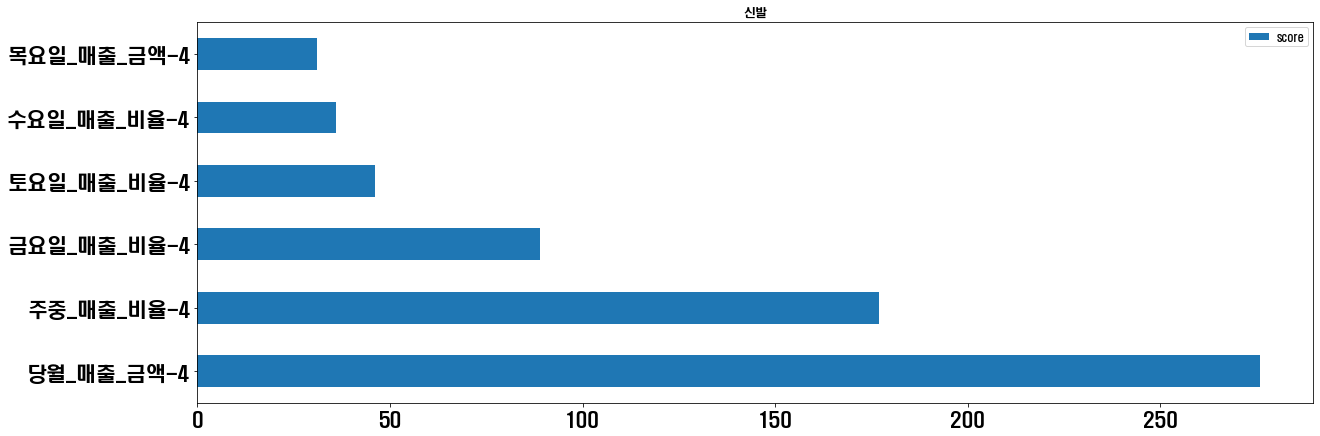

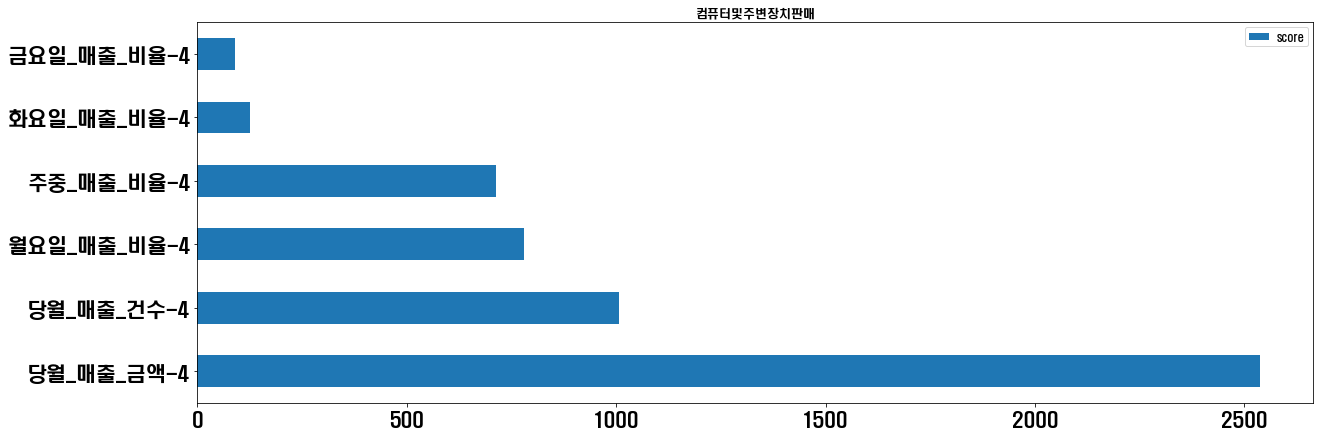

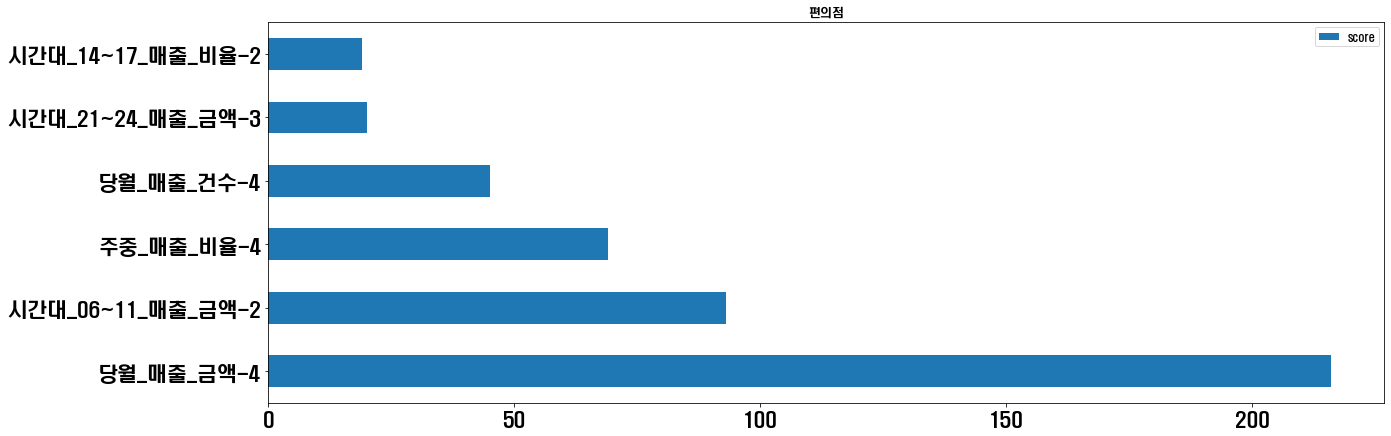

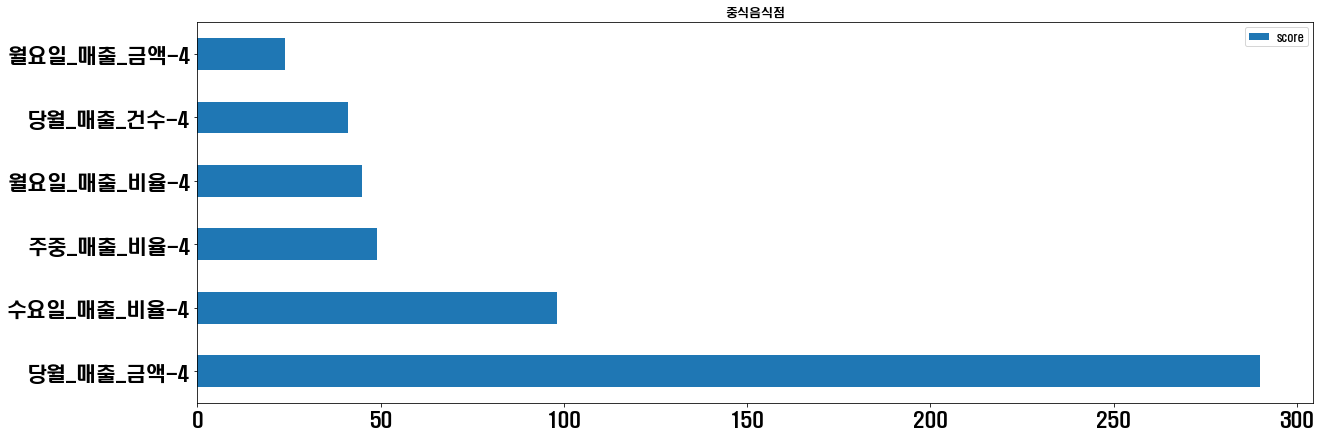

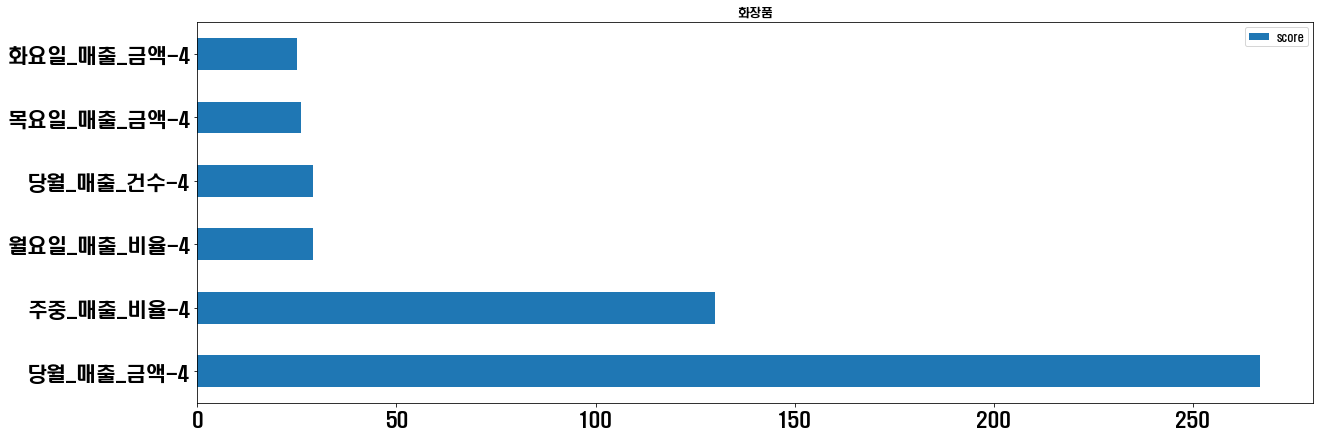

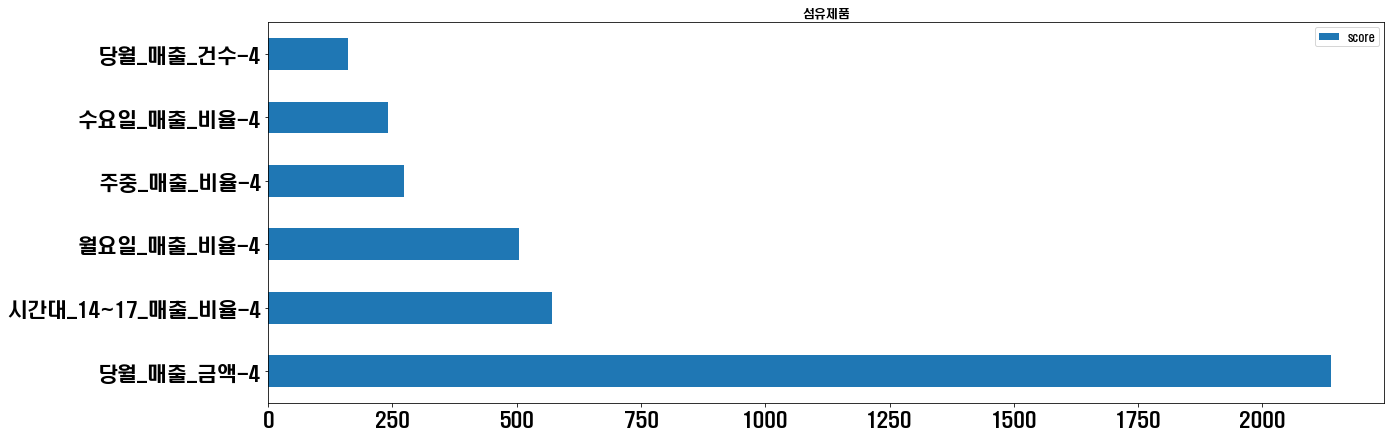

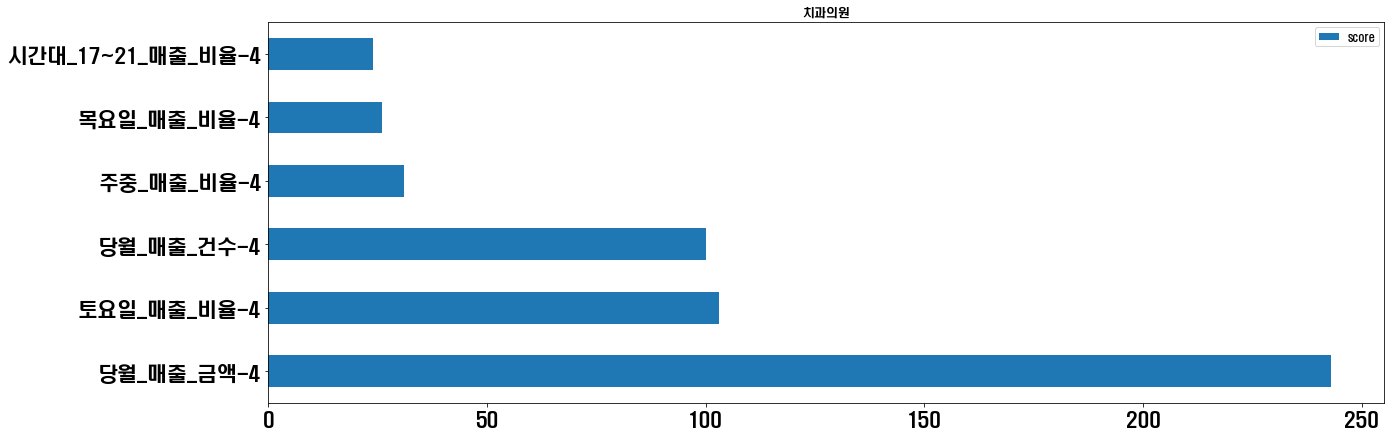

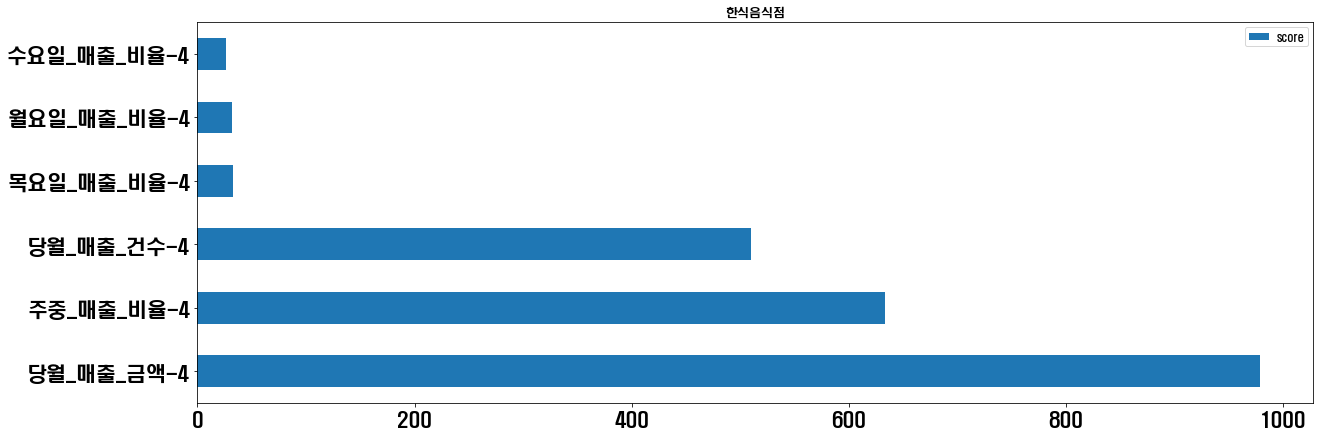

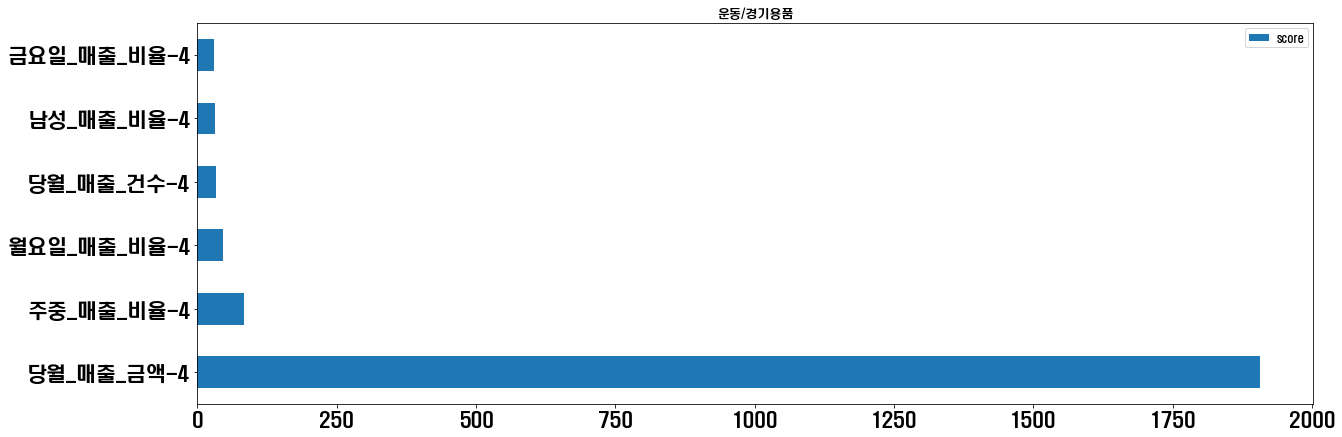

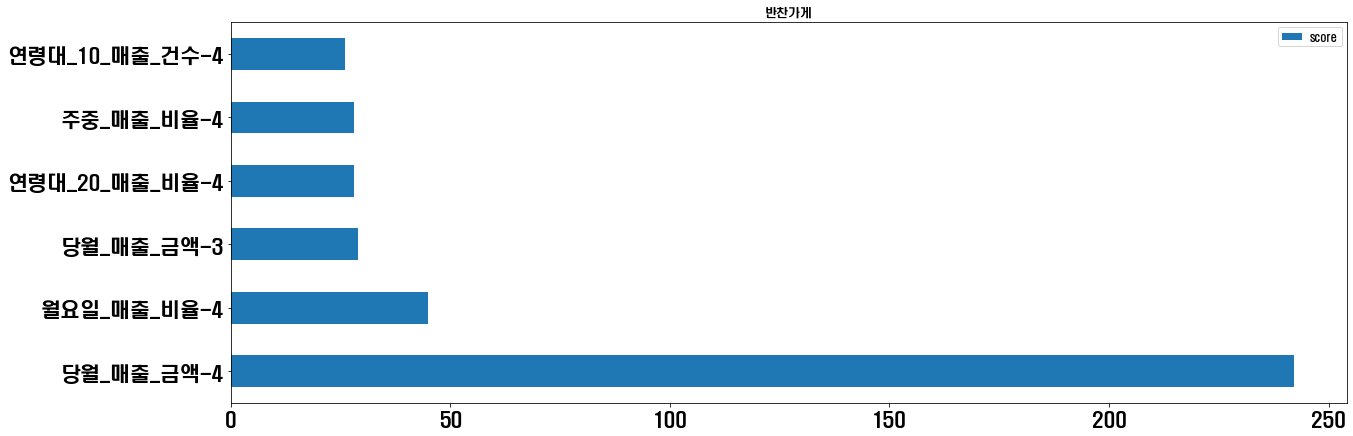

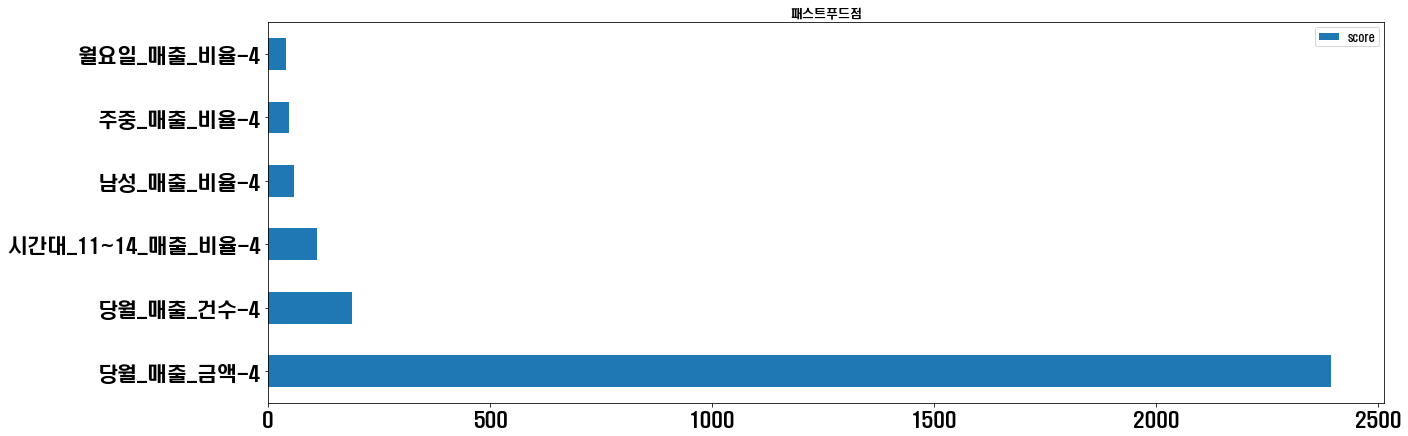

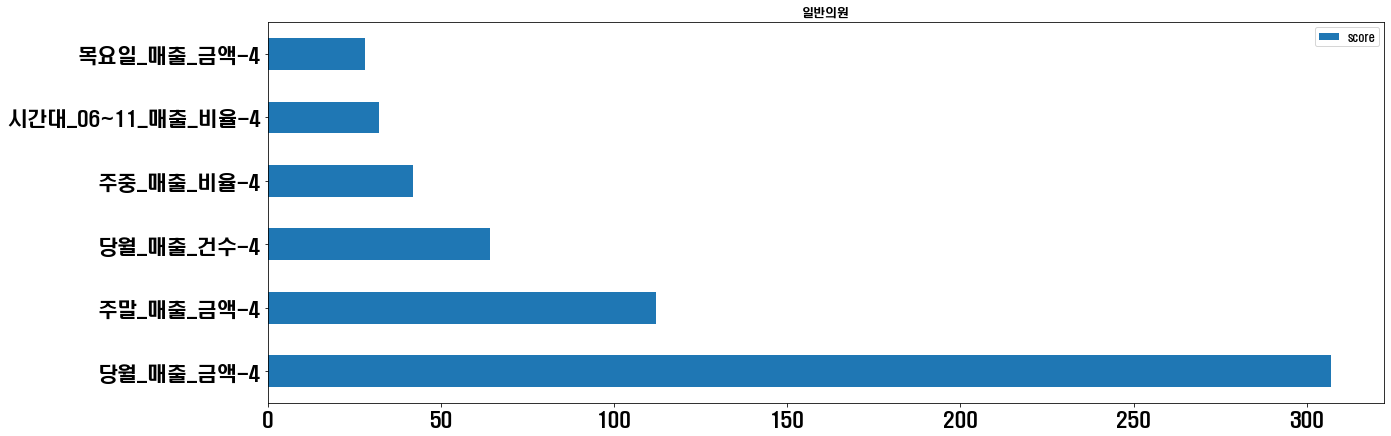

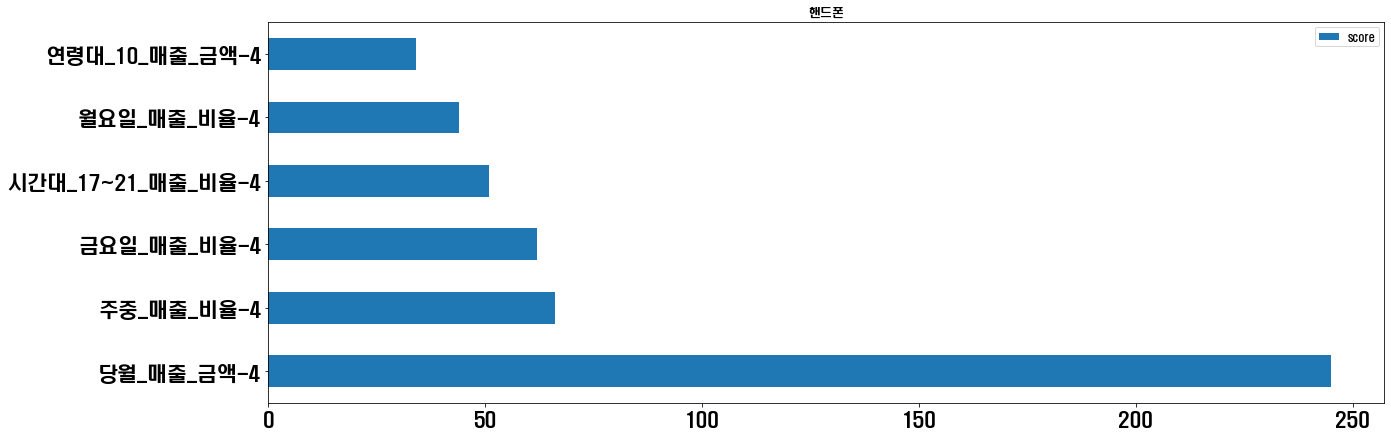

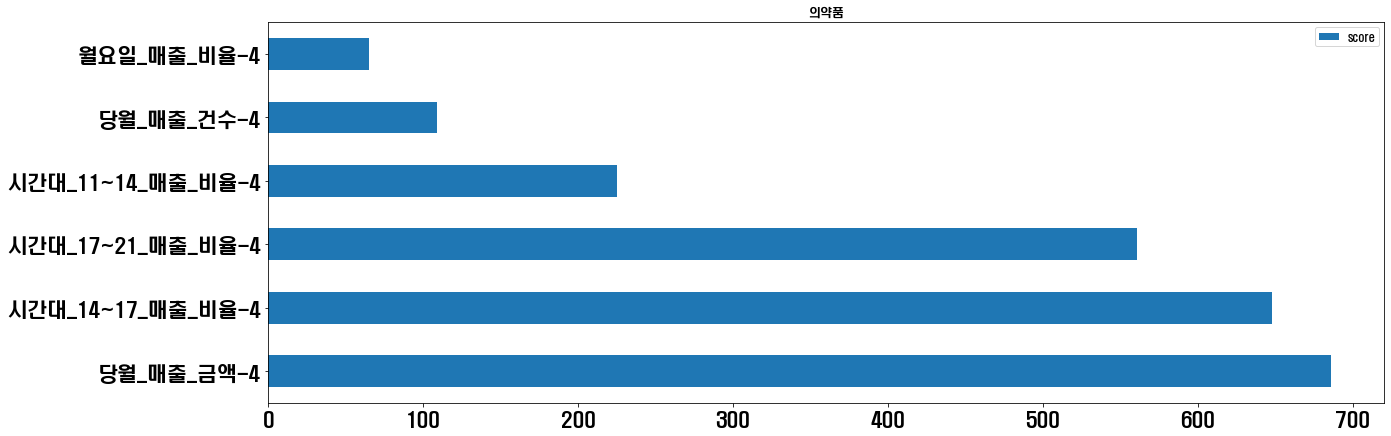

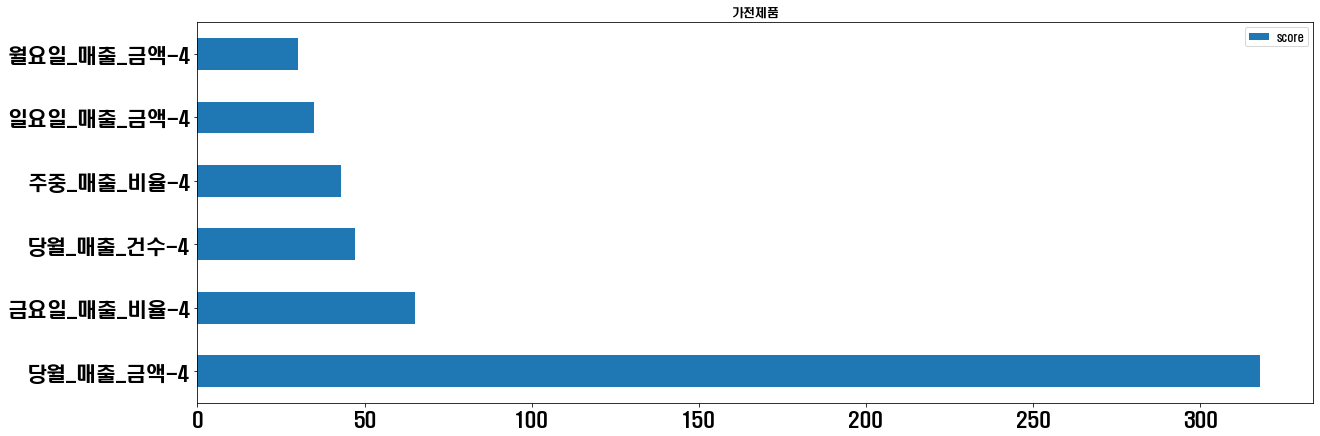

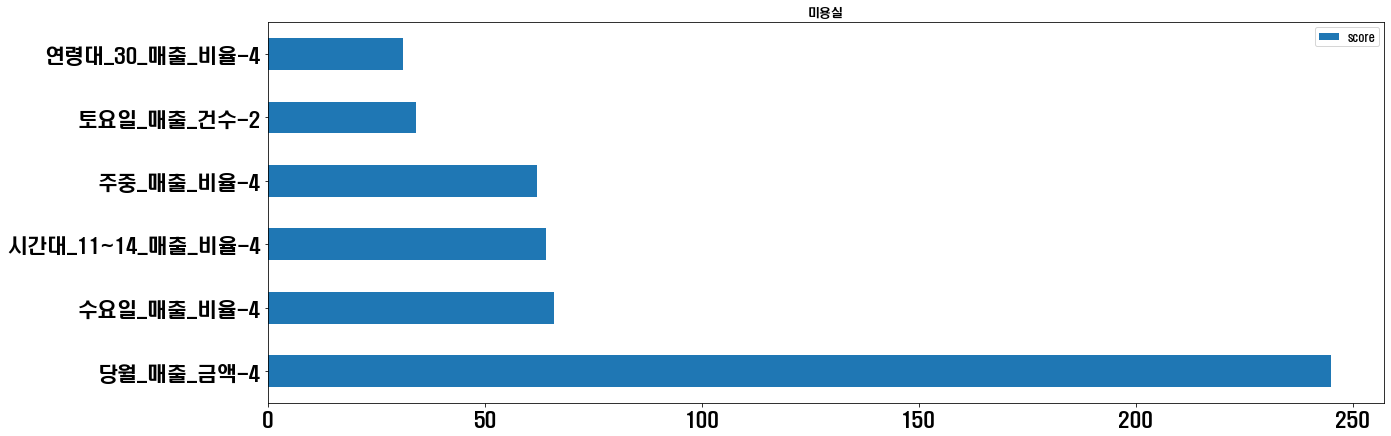

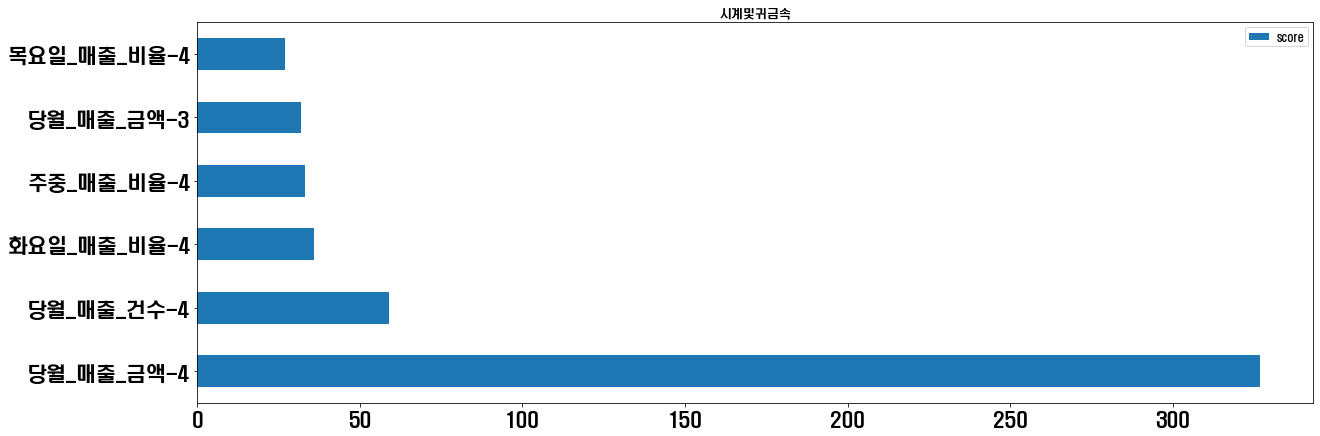

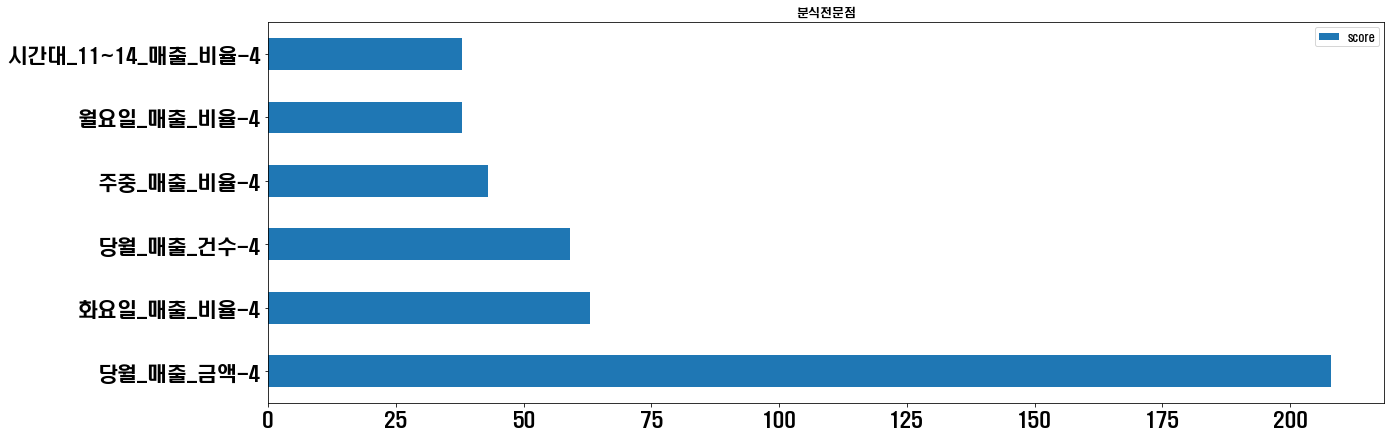

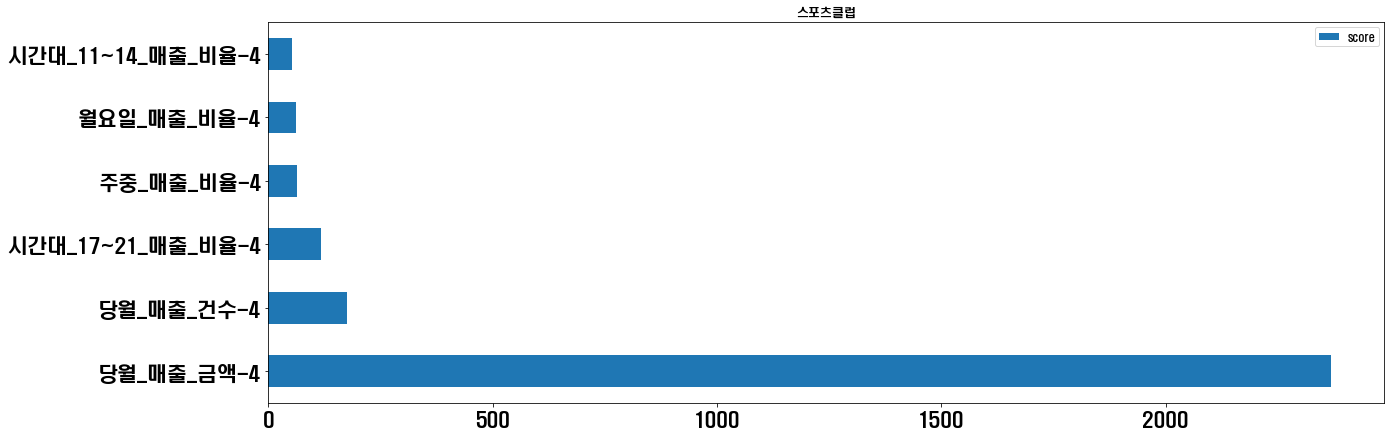

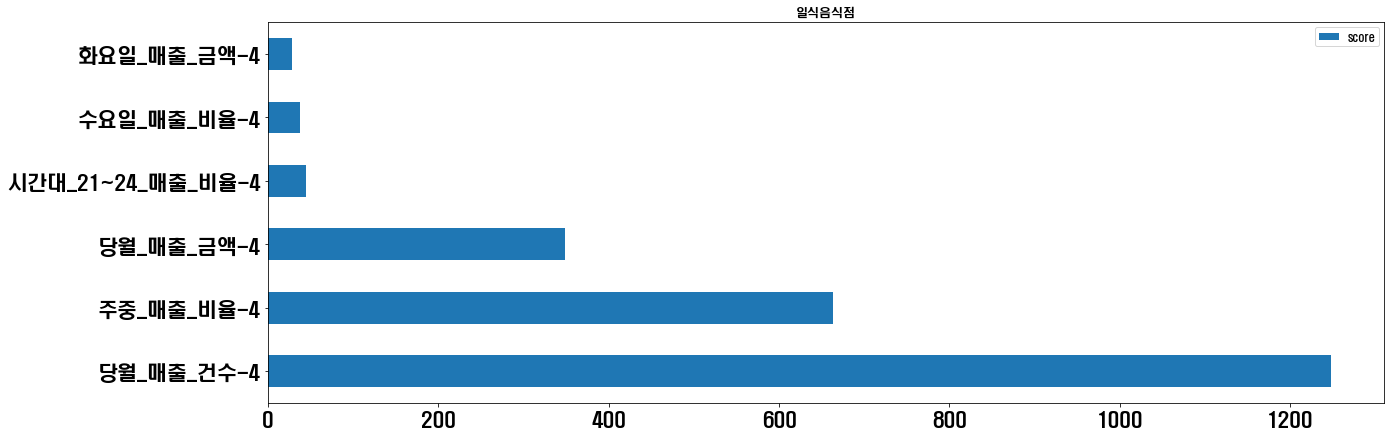

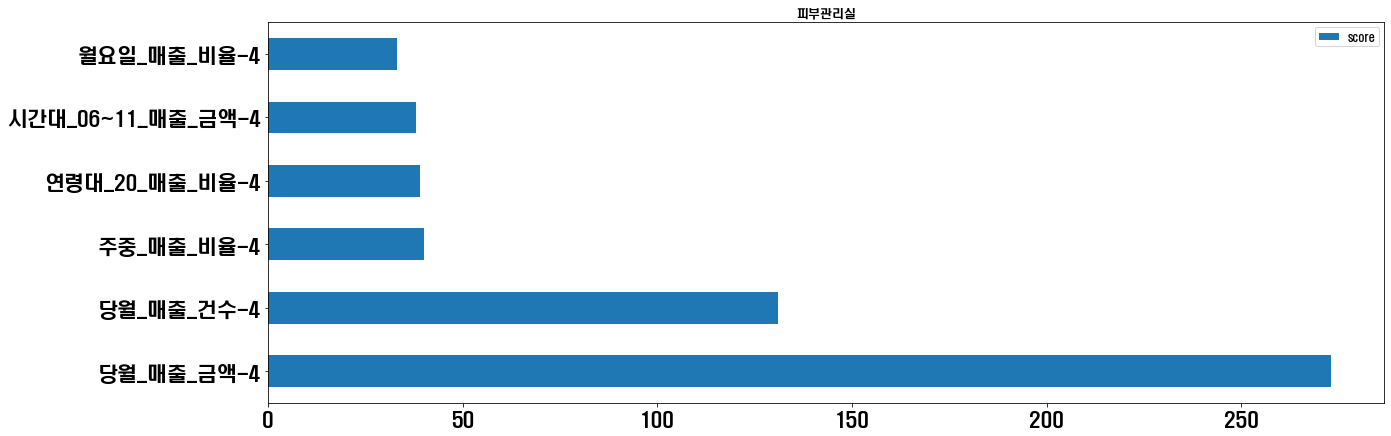

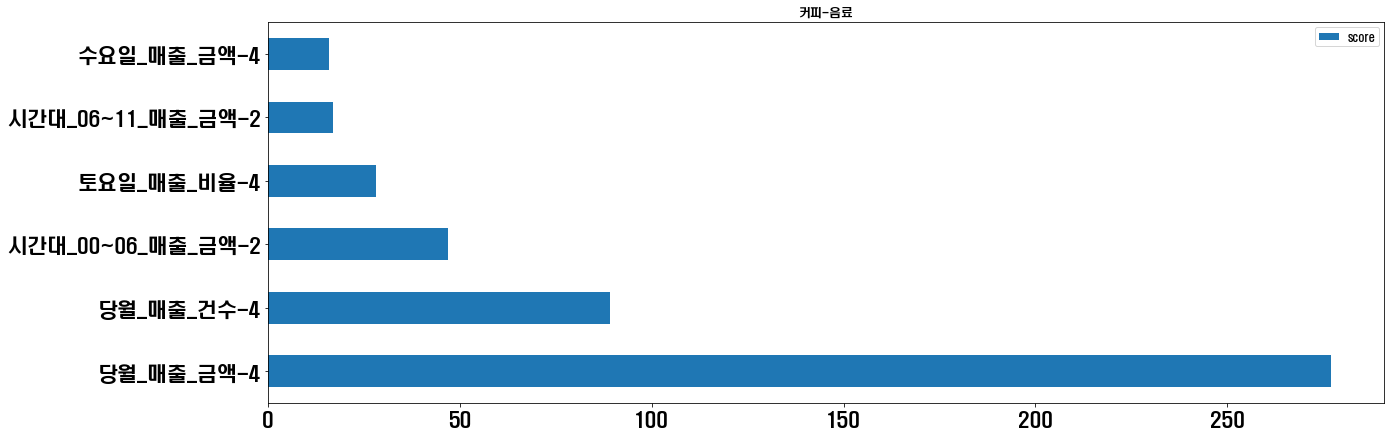

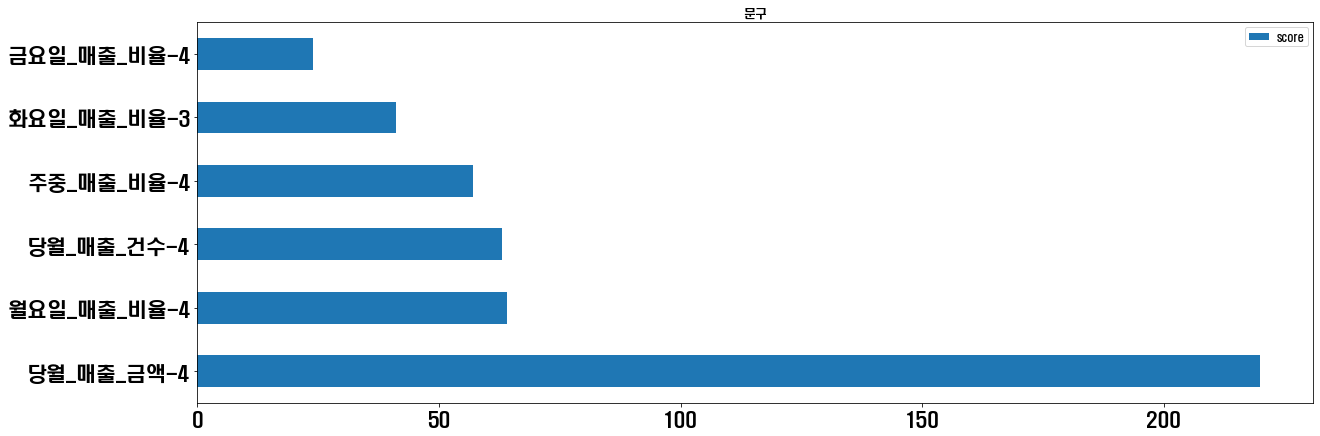

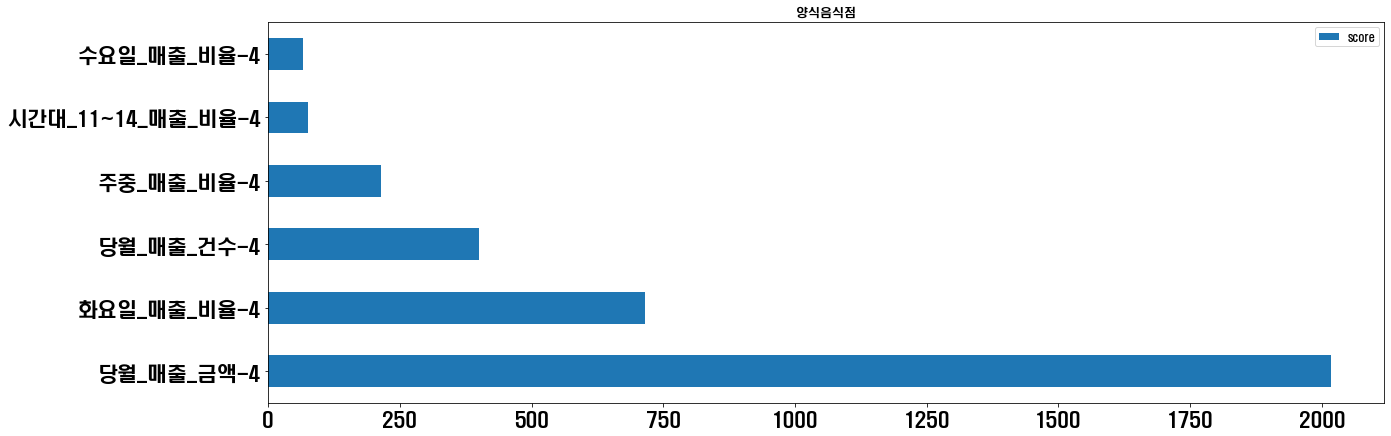

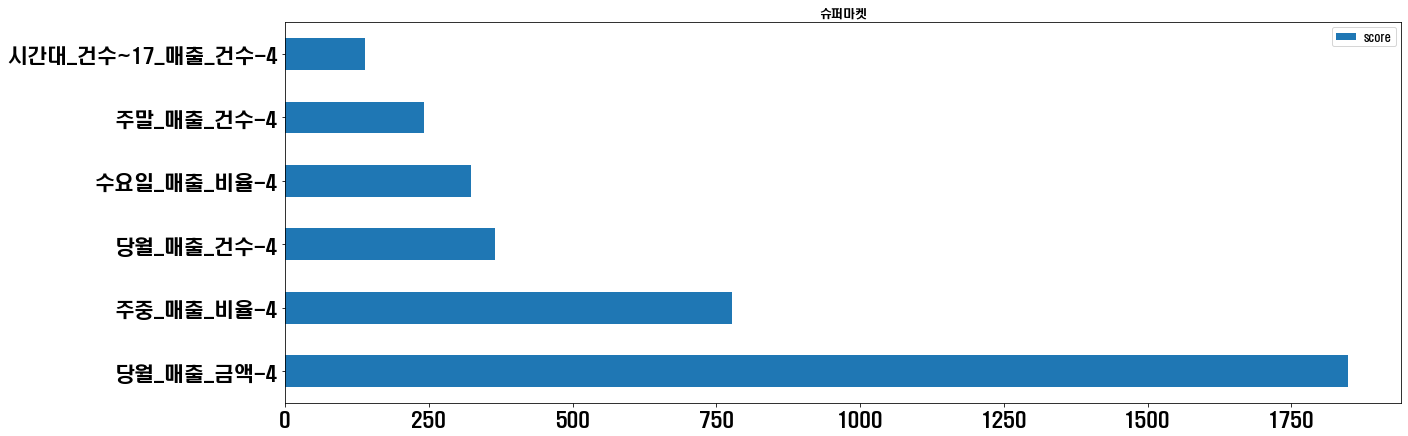

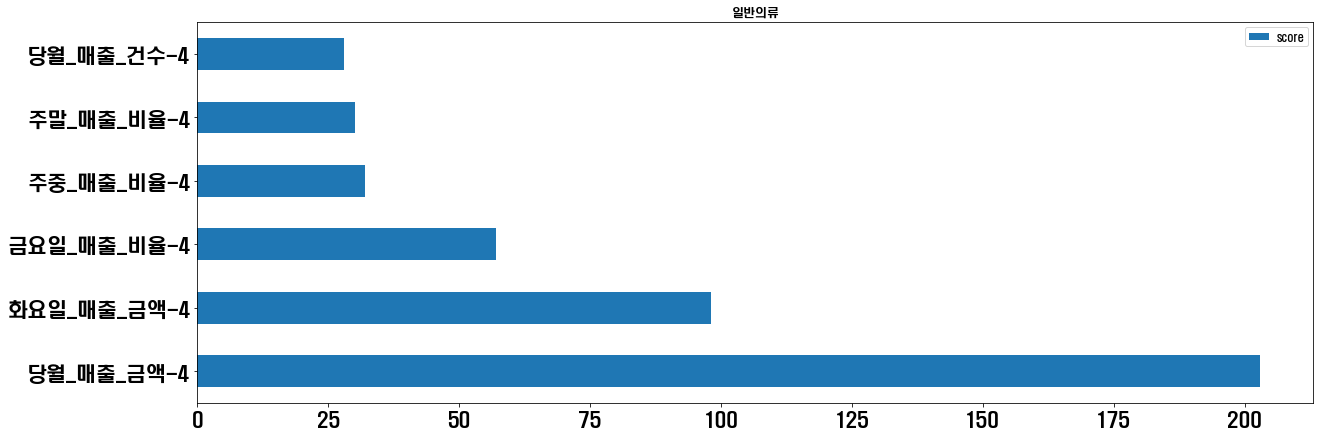

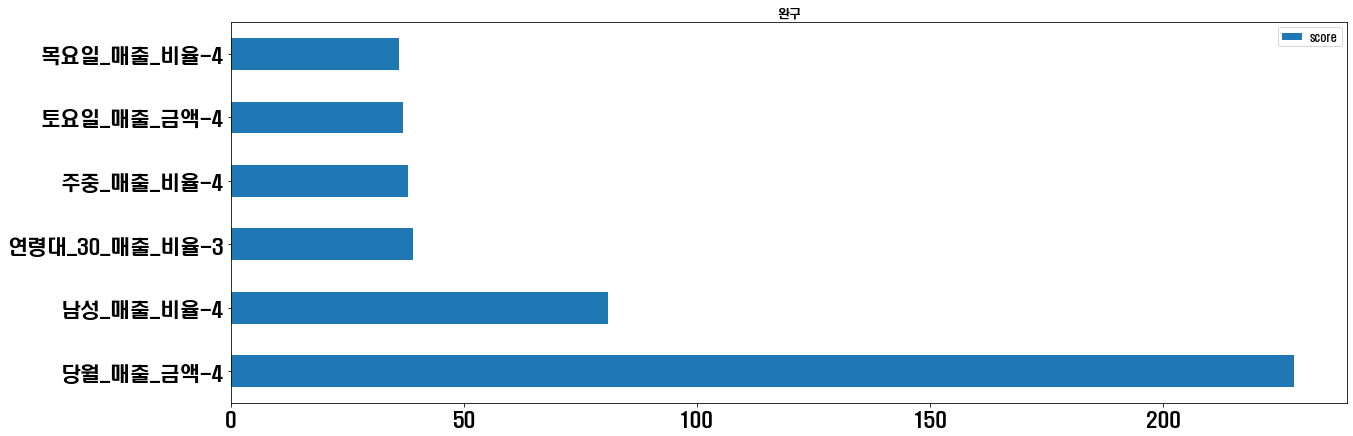

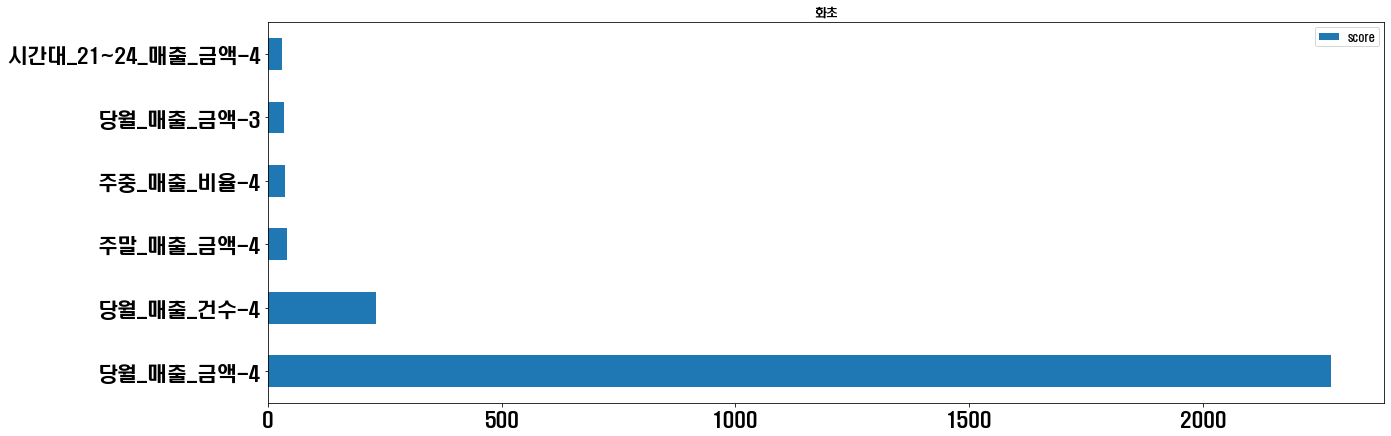

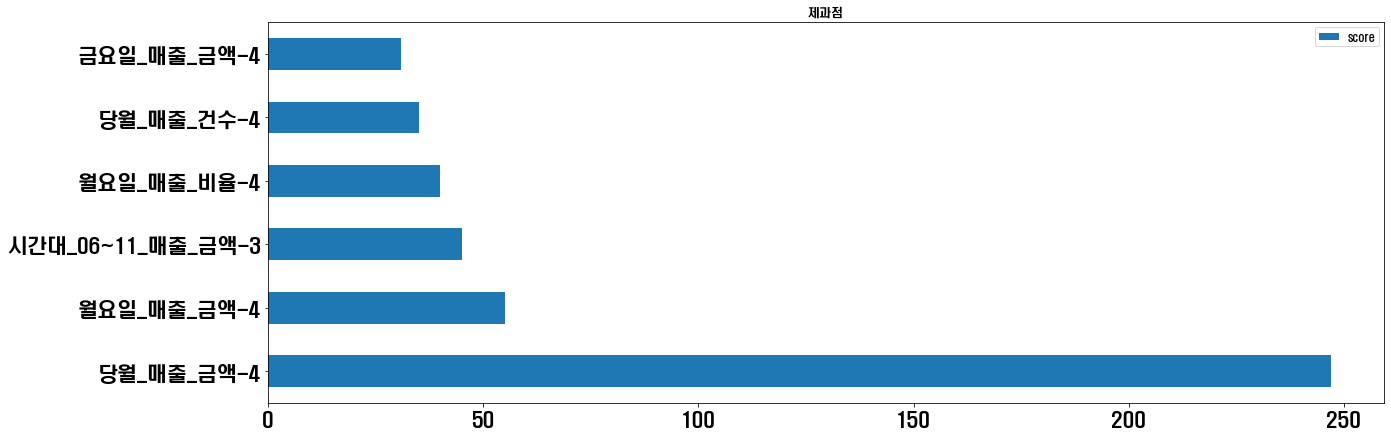

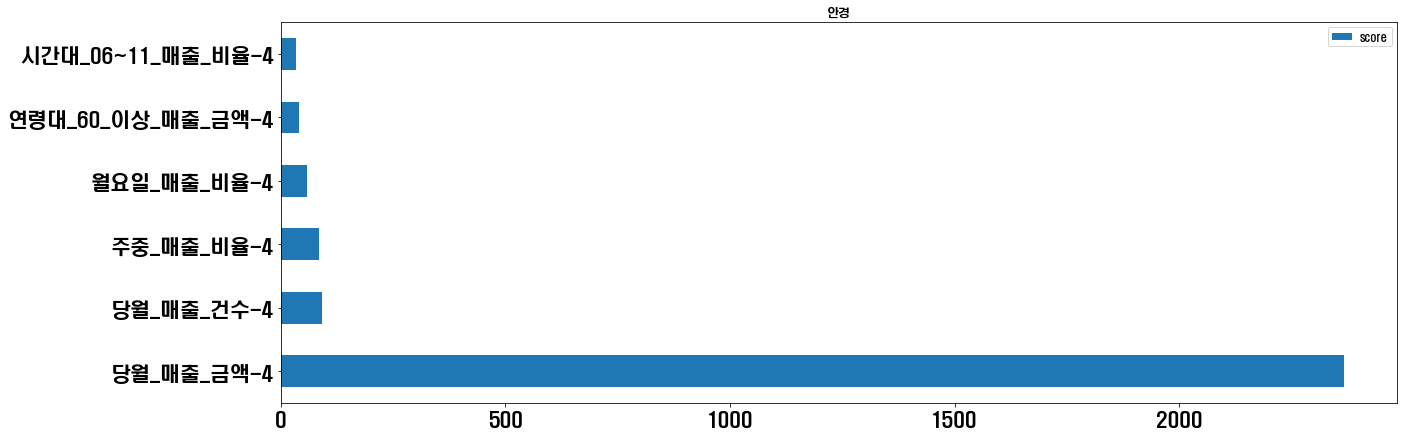

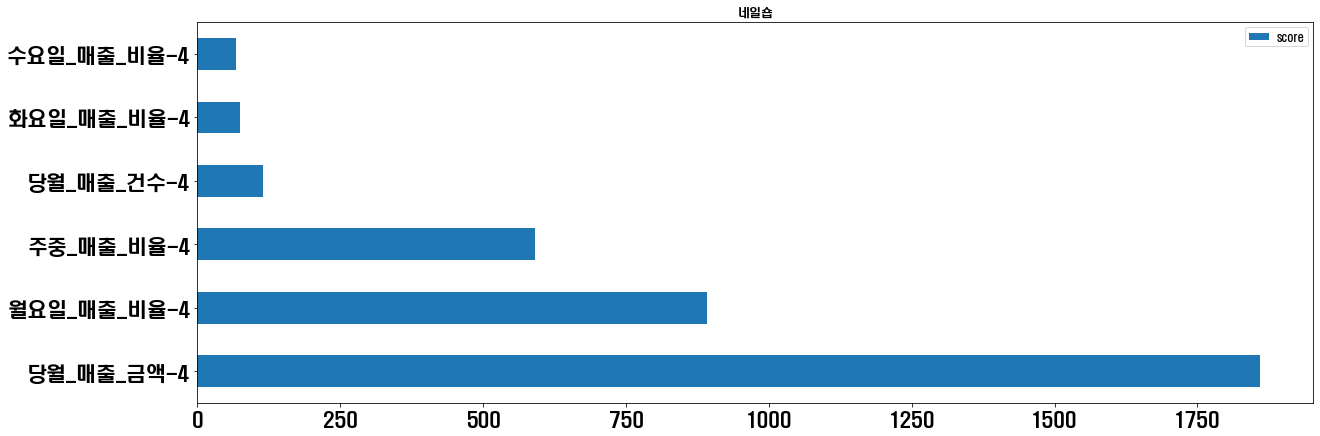

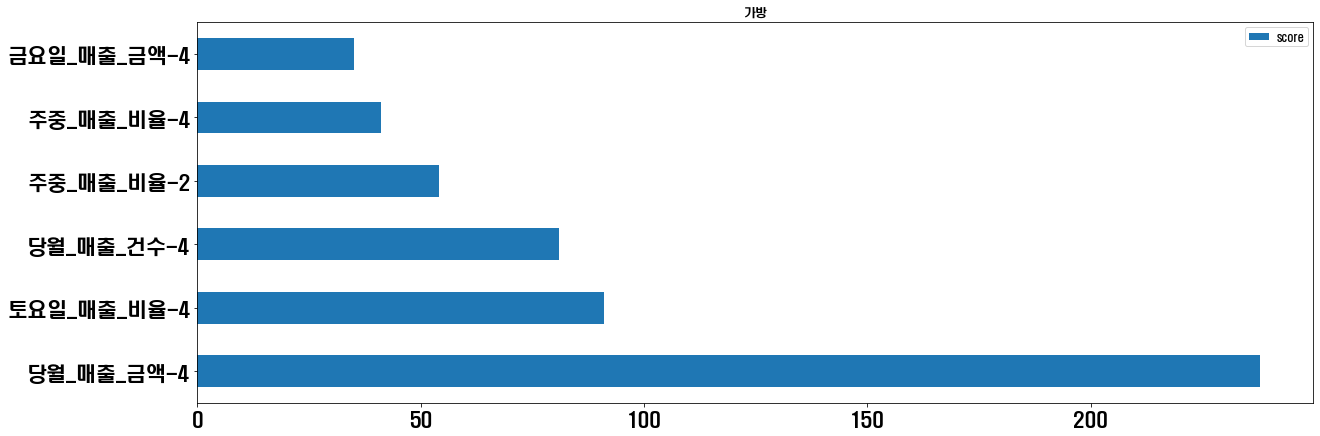

In [125]:
num_of_showing_features = 6
plt_w = 20
plt_h = 7
import matplotlib.pyplot as plt 
for j in range(len(service_names)):
    
    feature_important = globals()["xgb_{}".format(service_names[j])].get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    plt.rcParams["figure.figsize"] = (plt_w,plt_h)
    globals()["data_{}".format(service_names[j])] = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    globals()["data_{}".format(service_names[j])][:num_of_showing_features].plot(kind='barh',title=service_names[j],fontsize=20)
    


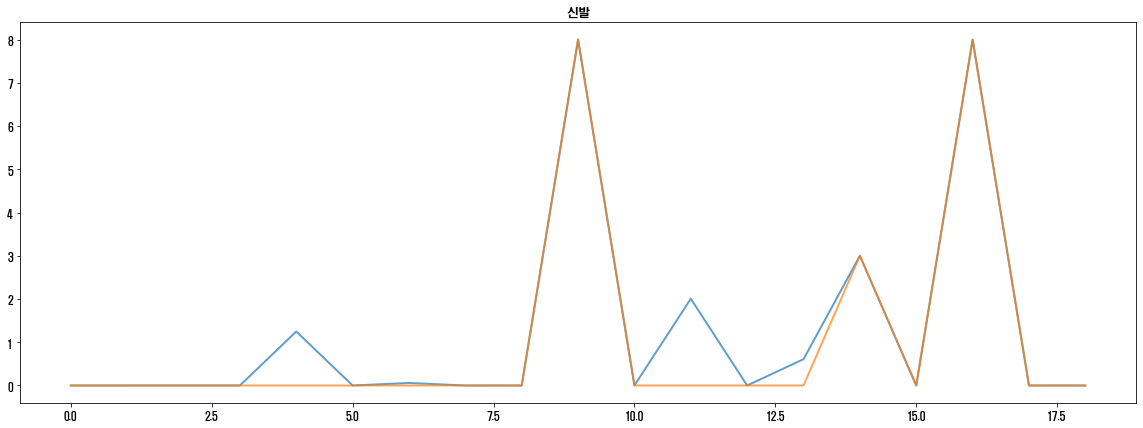

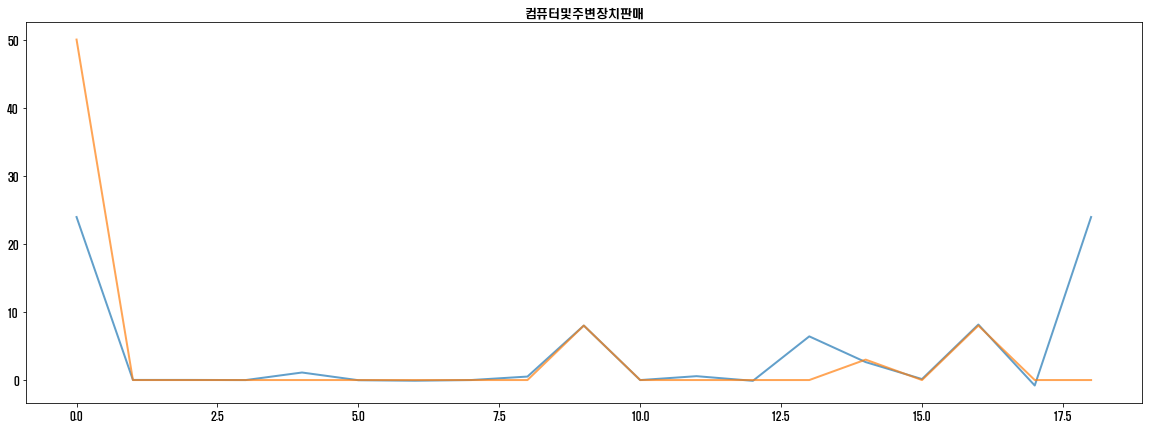

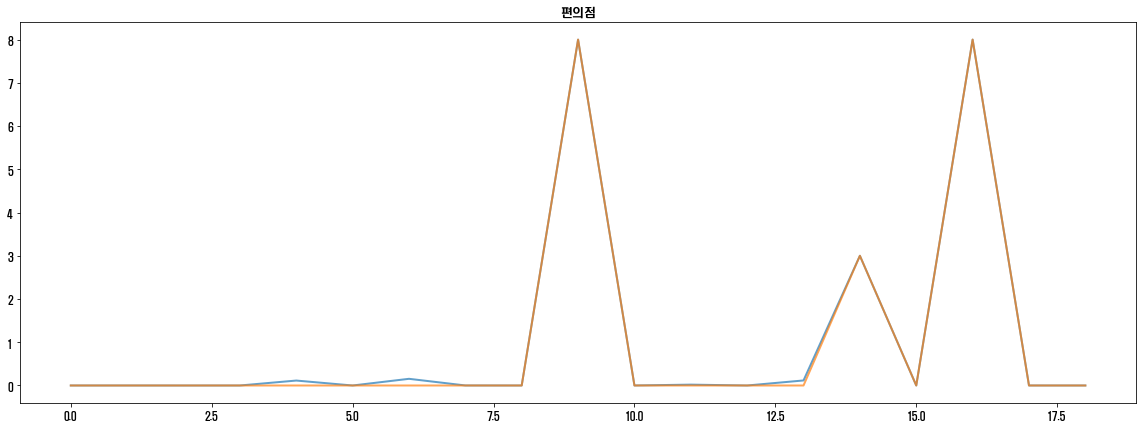

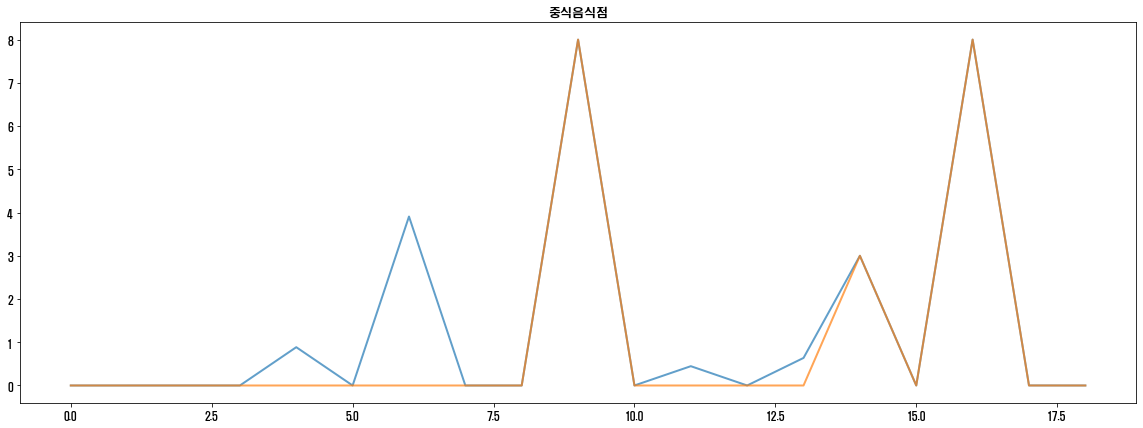

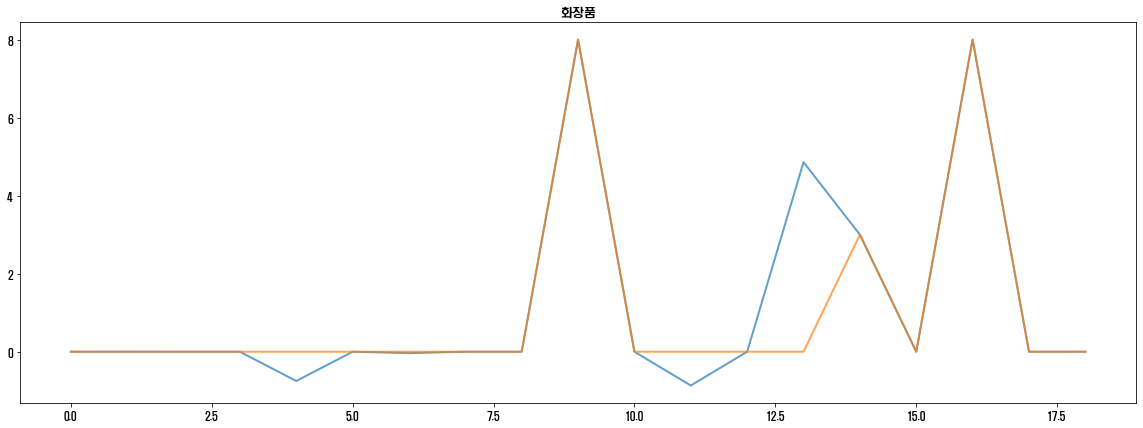

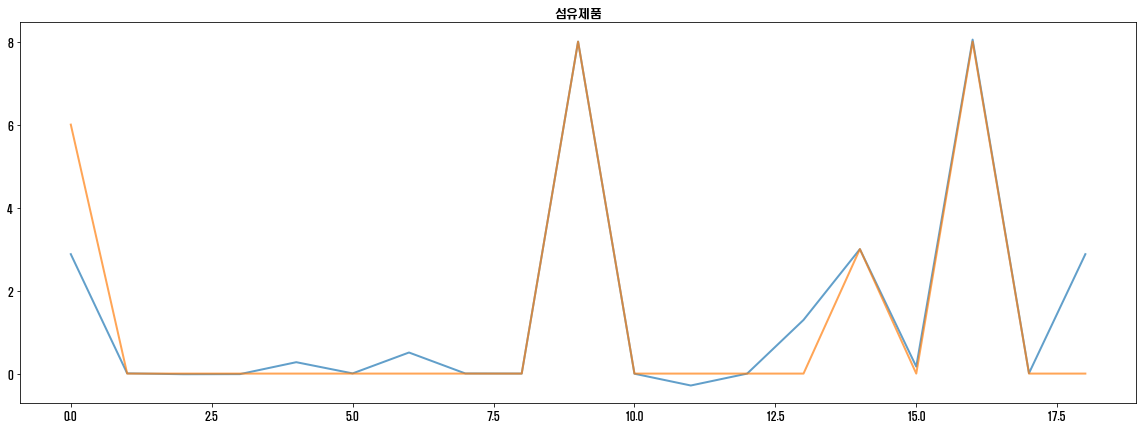

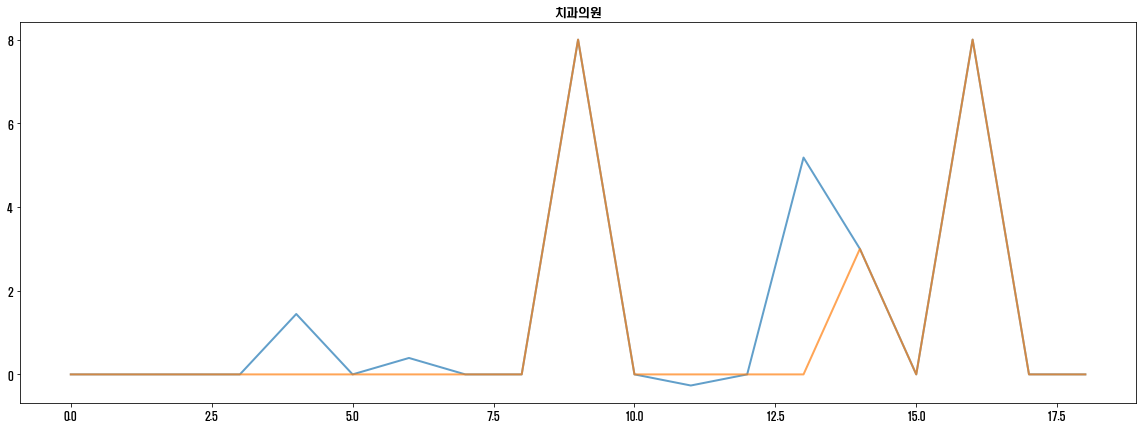

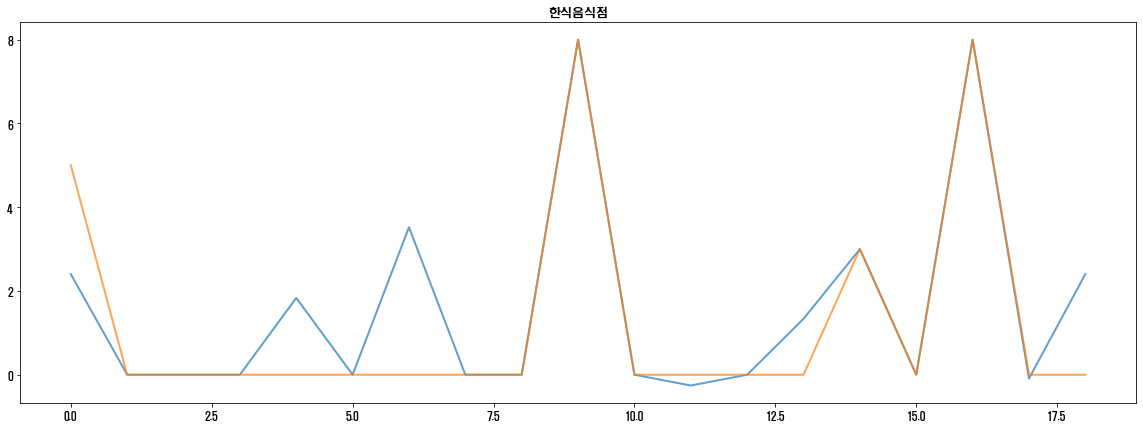

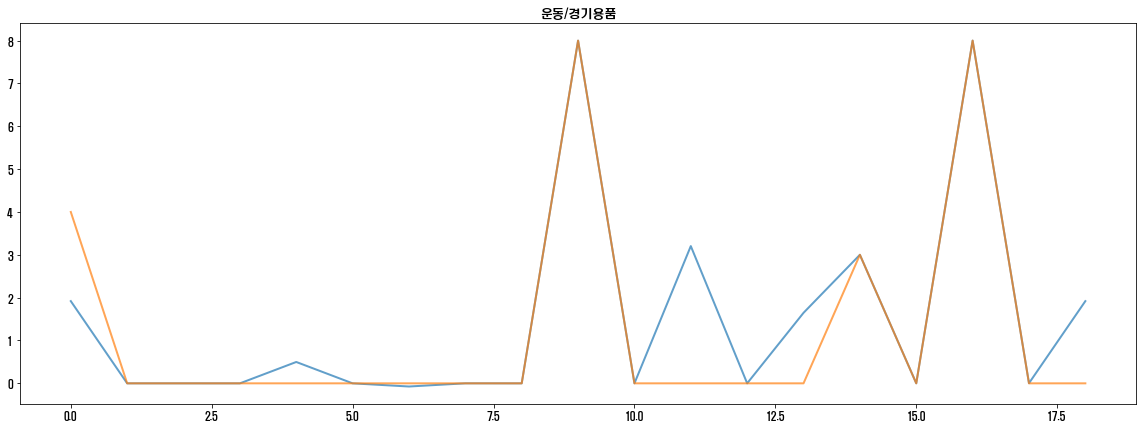

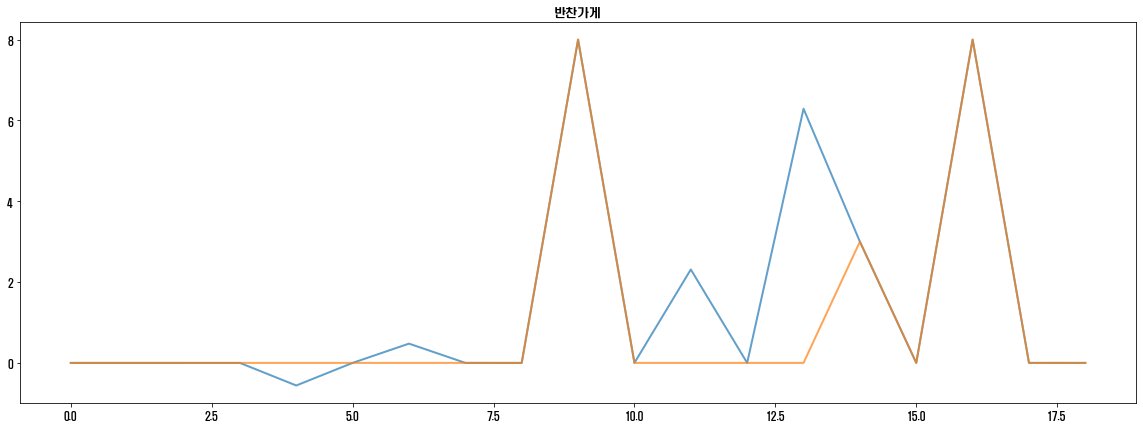

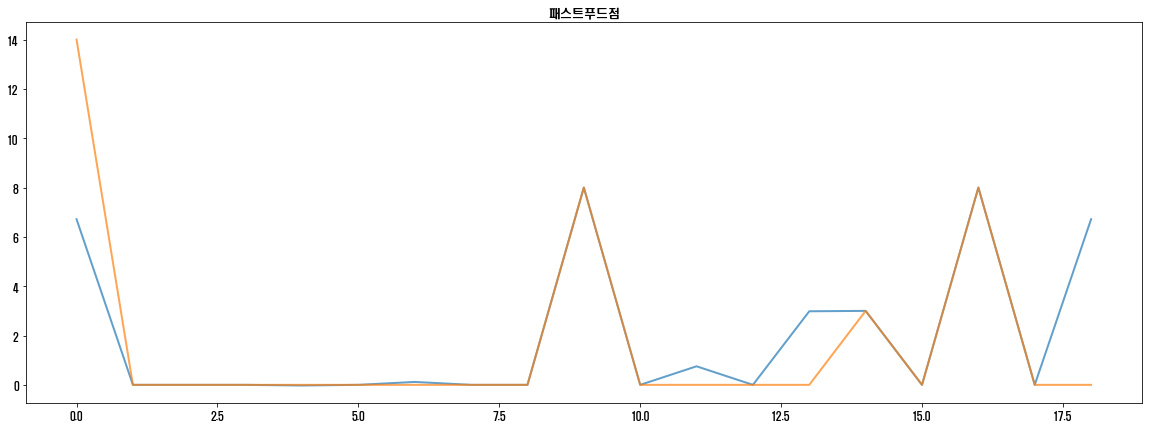

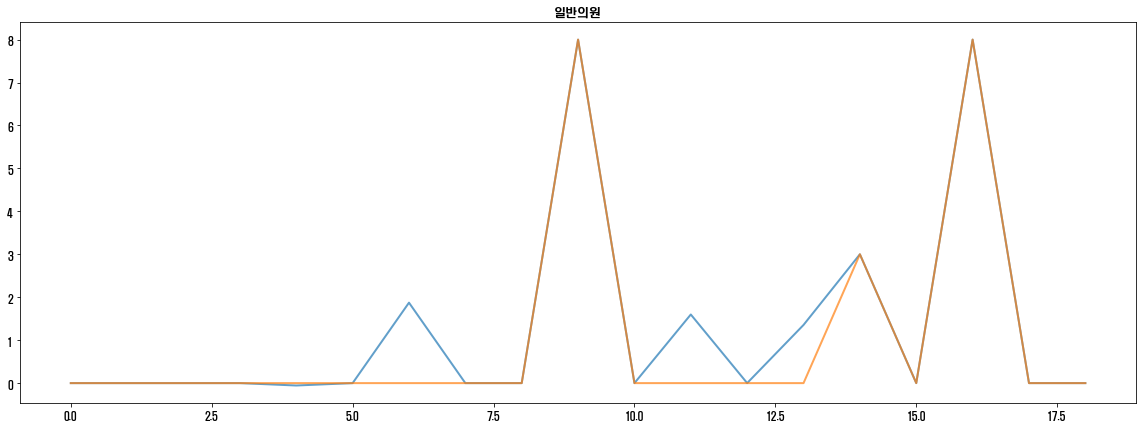

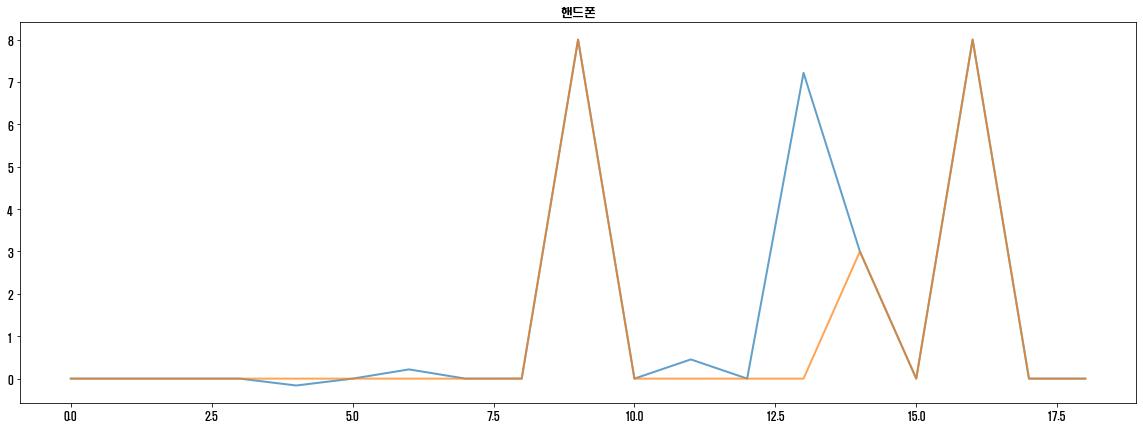

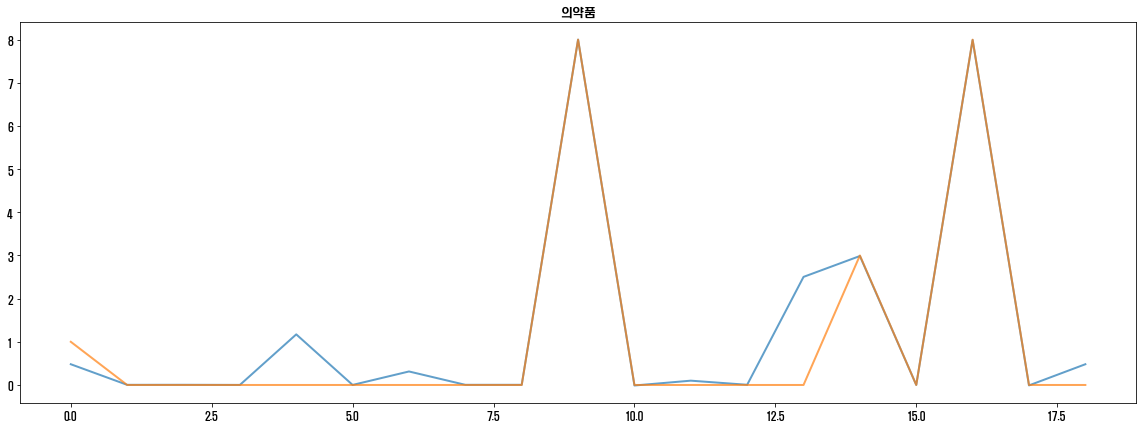

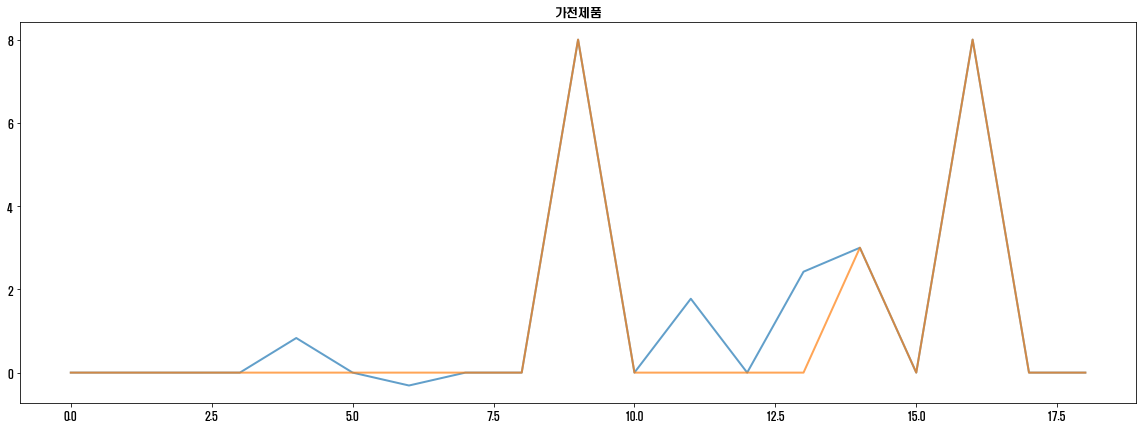

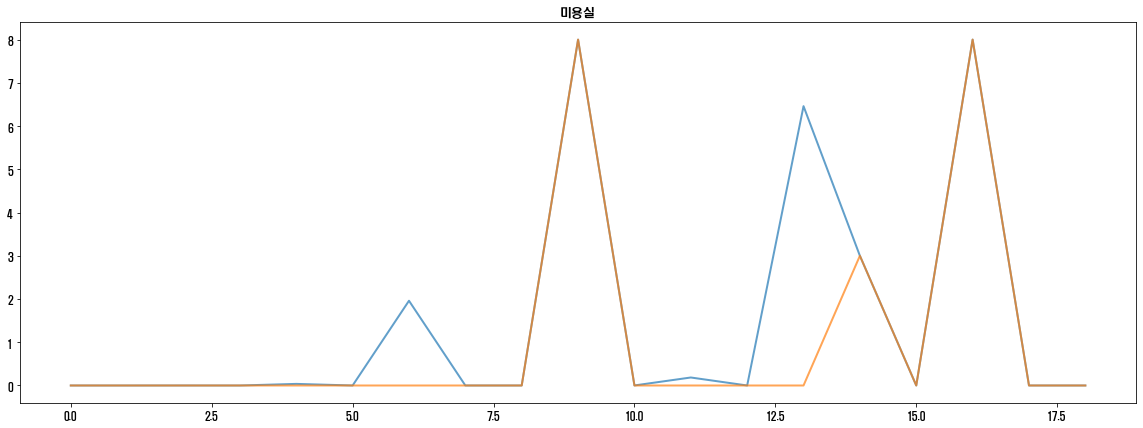

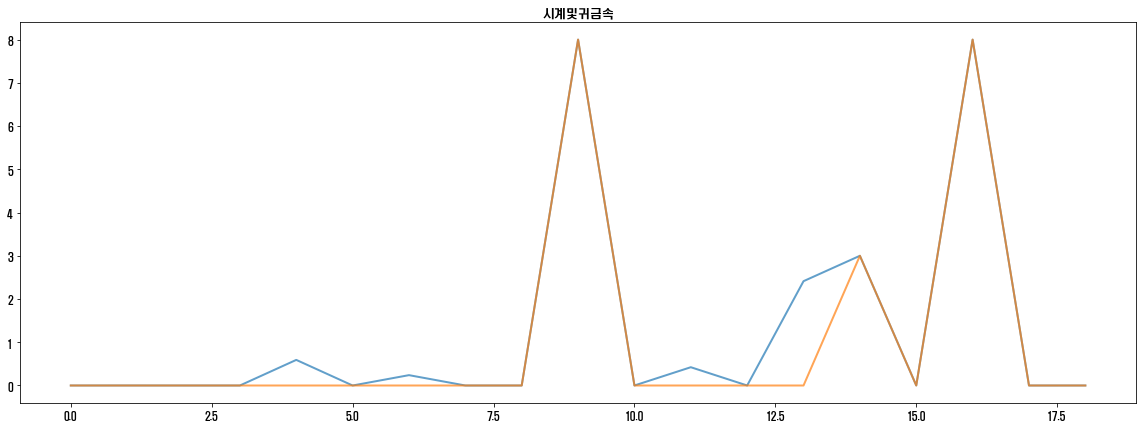

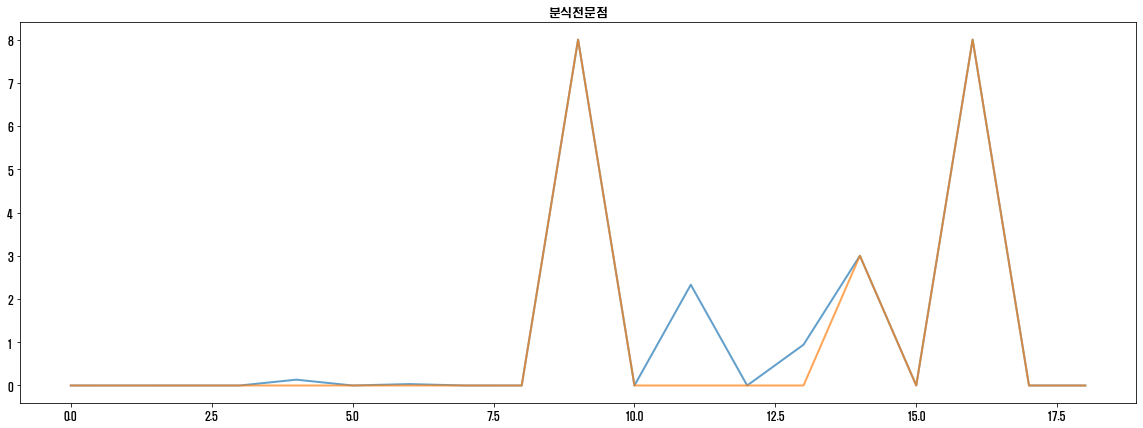

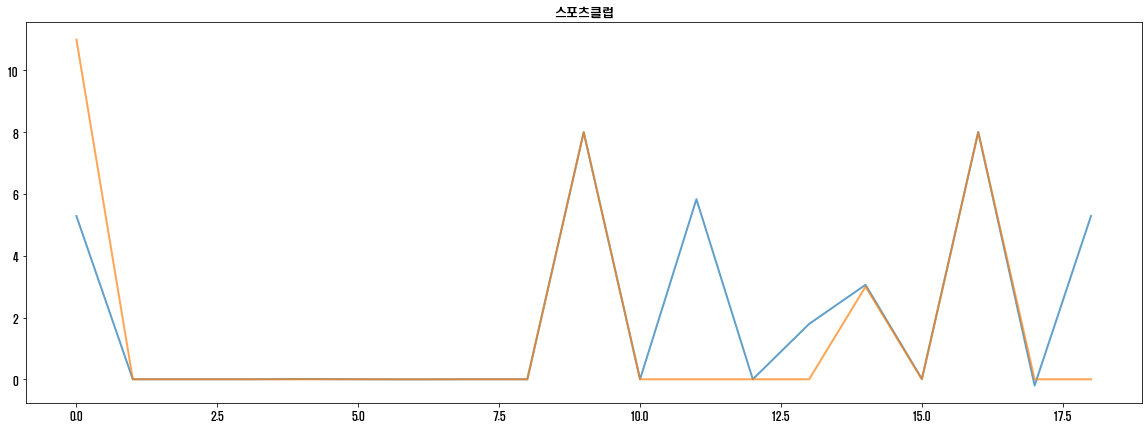

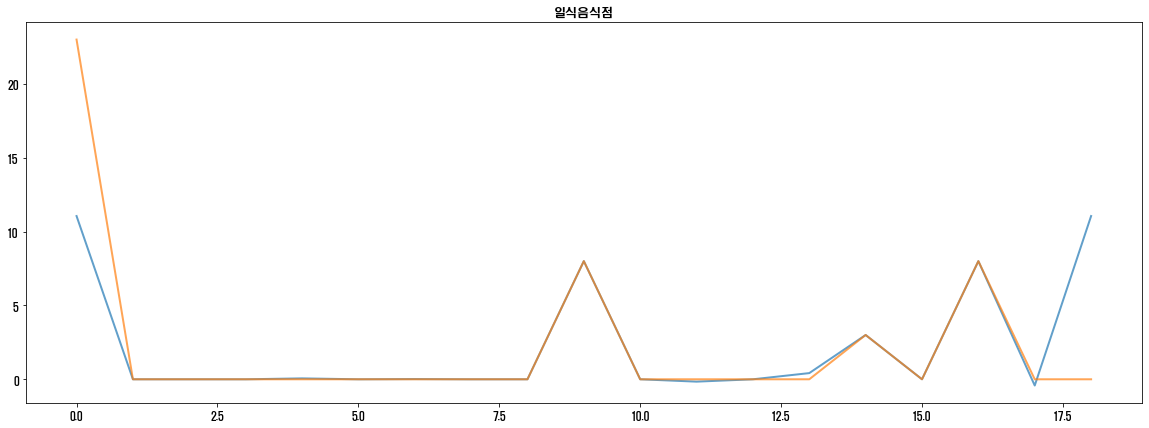

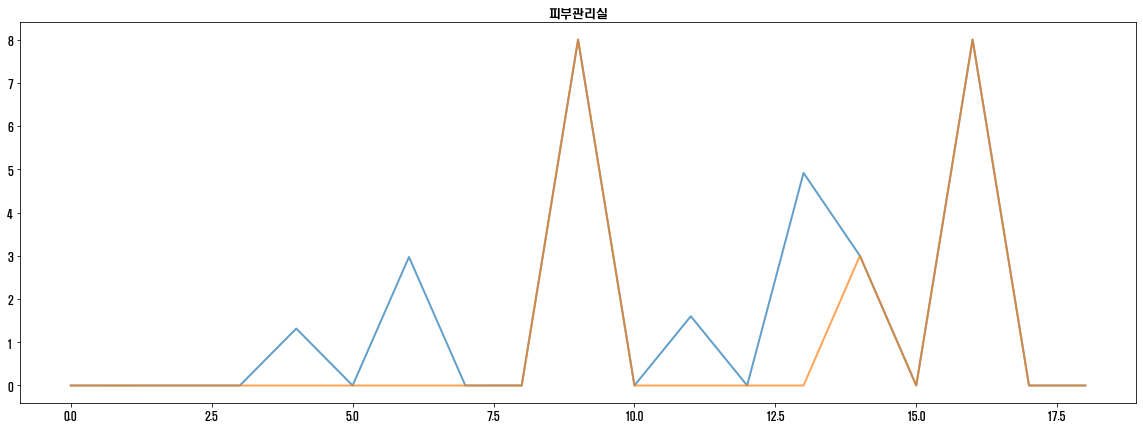

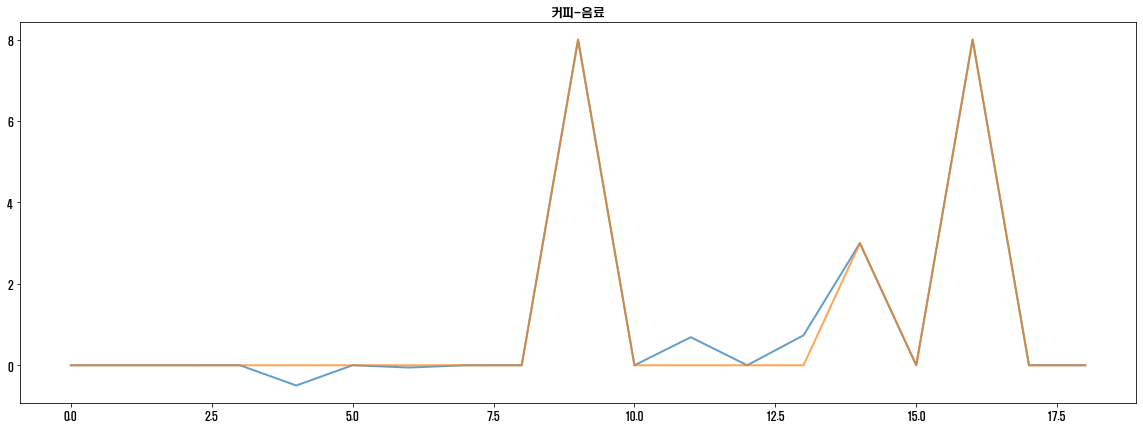

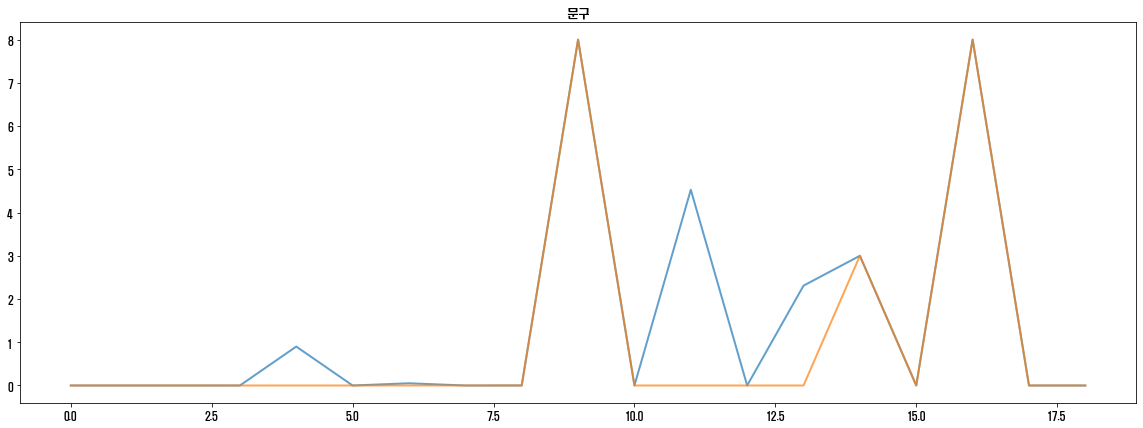

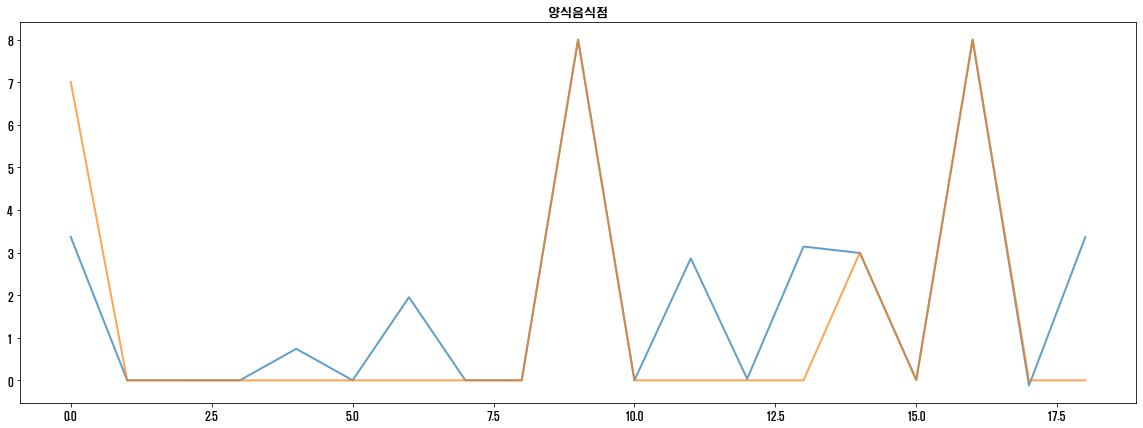

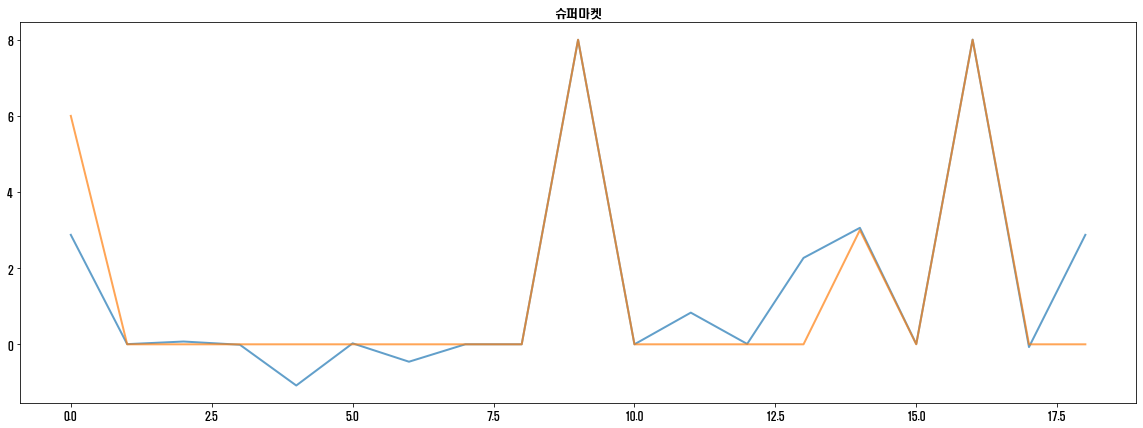

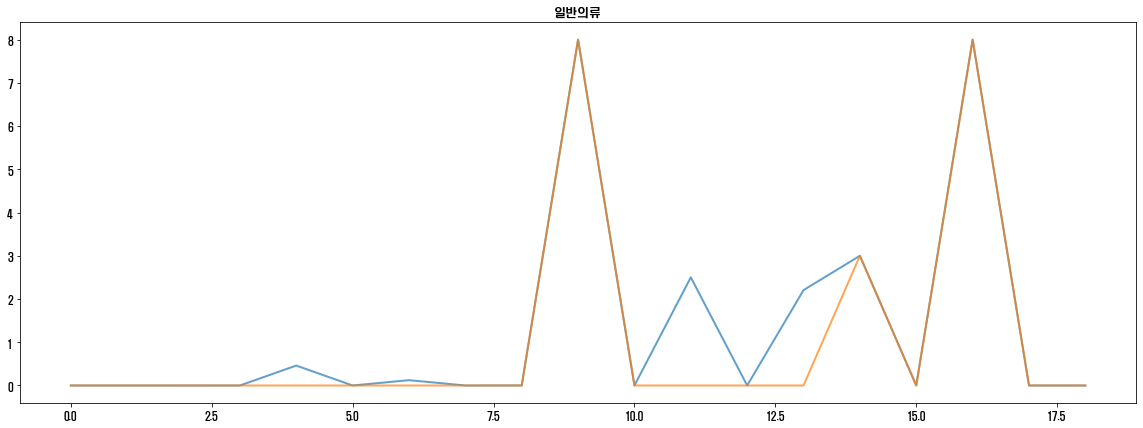

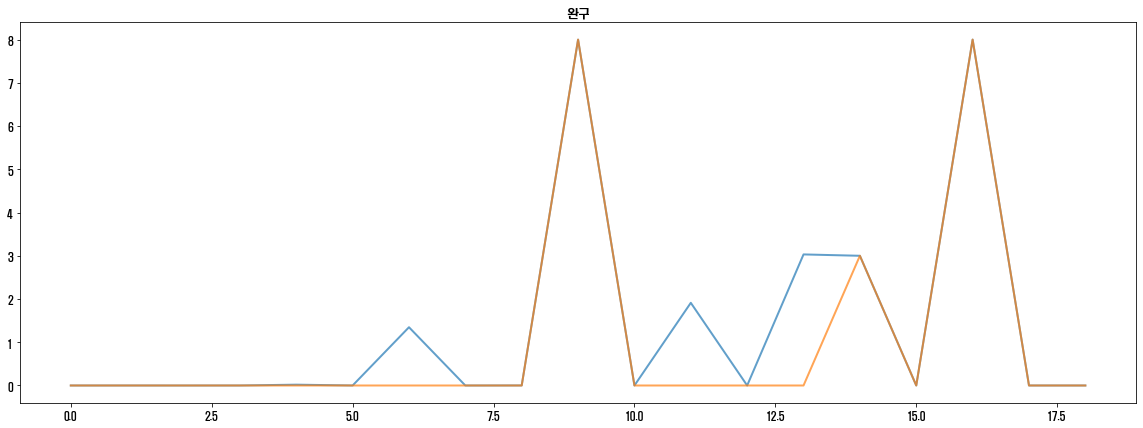

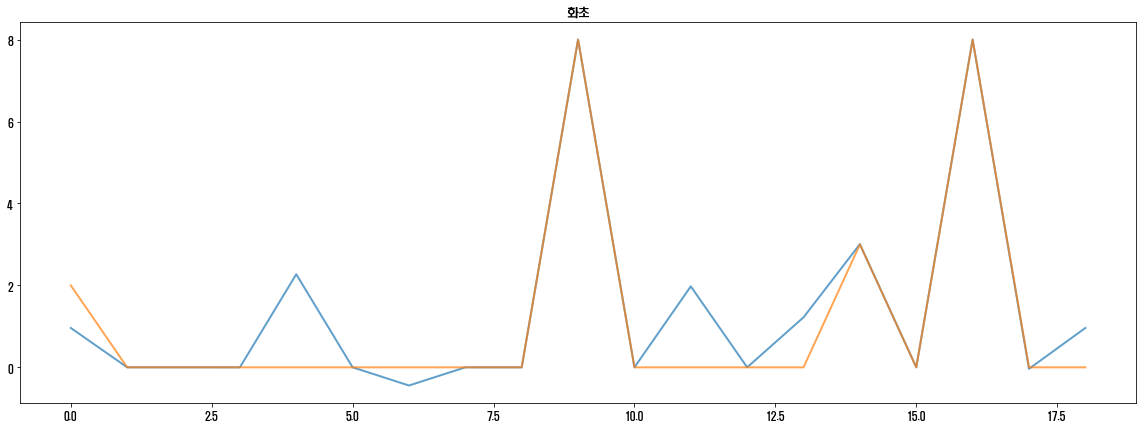

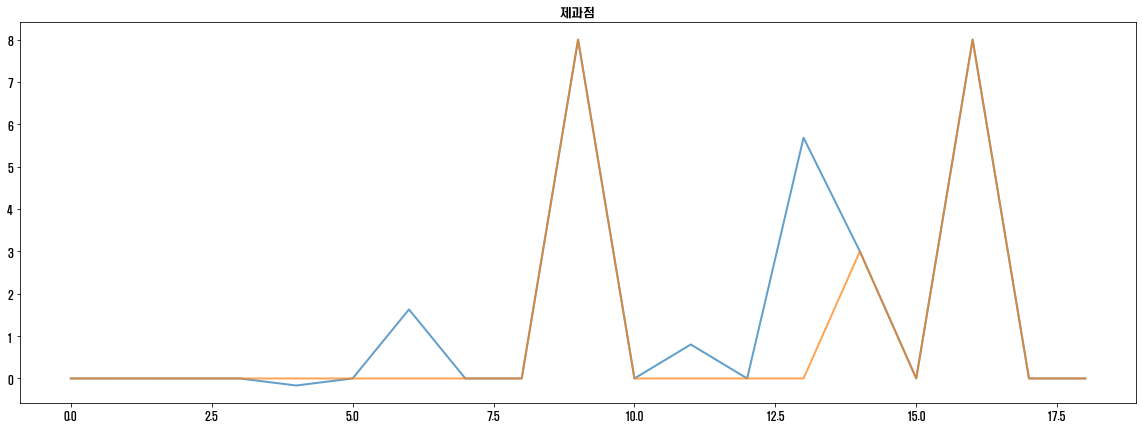

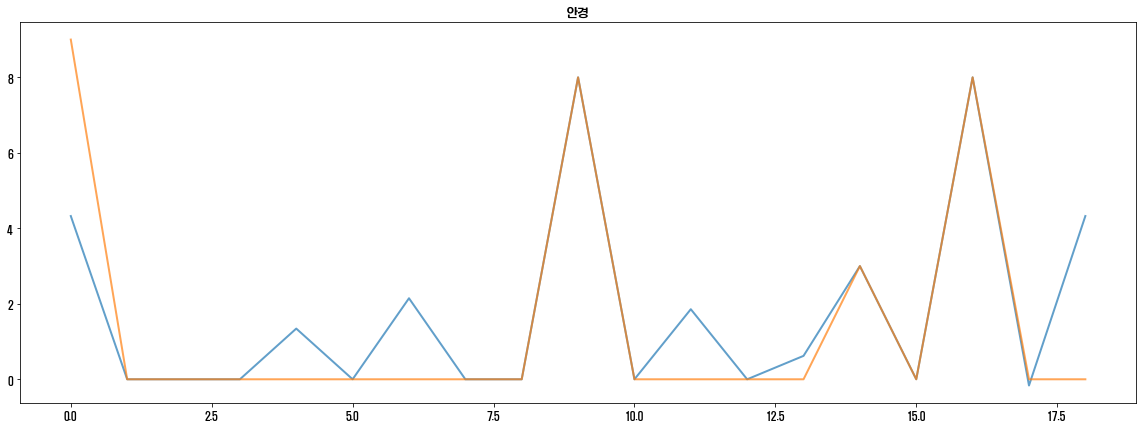

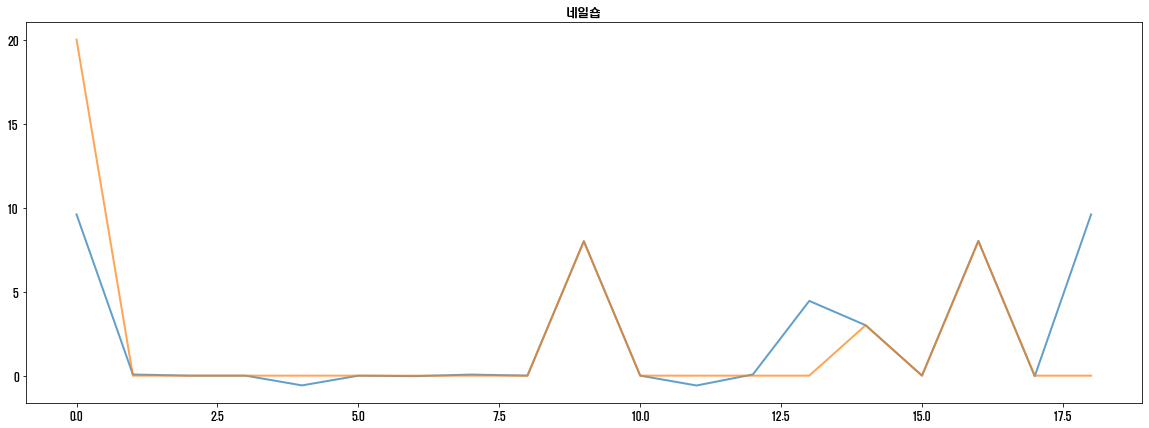

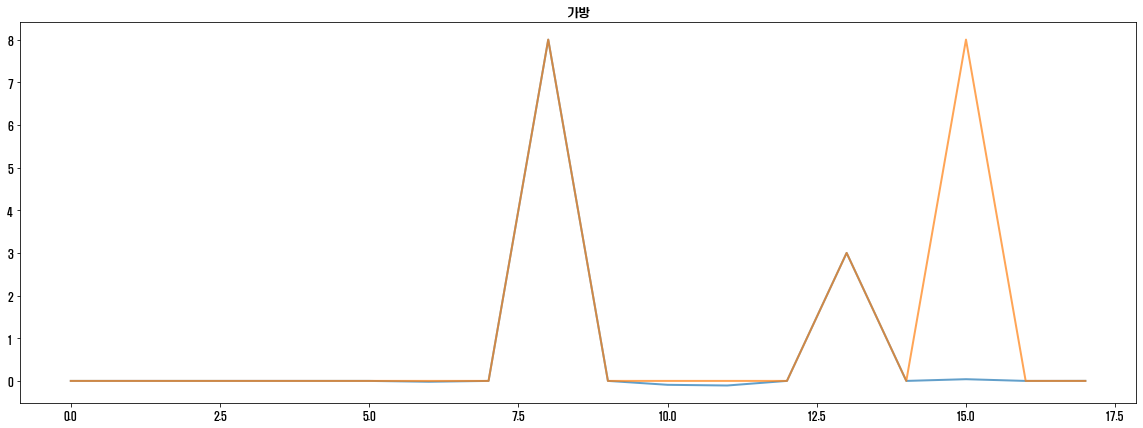

In [132]:
import matplotlib as plt 
for j in range(len(service_names)):
    plt.pyplot.figure()
    plt.pyplot.plot(globals()["xgb_{}".format(service_names[j])].predict(globals()["{}_x_in".format(service_names[j])].astype('float64')),alpha = 0.7,linewidth = 2)
    # 파란색 : 예측값
    # 주황색 : 실제값
    # 갈색 : 파란색과 주황색이 겹치는 부분
    plt.pyplot.plot(globals()["{}_x_out".format(service_names[j])].values, alpha = 0.7,linewidth = 2)
    plt.pyplot.title(service_names[j])
    plt.pyplot.show()